<a href="https://colab.research.google.com/github/joycekuohmoukouri/creditworthiness-scoring/blob/main/KuohMoukouri_Joyce_A_notebook_extraction_features_072023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet 7 : Implémentez un modèle de scoring

## NB A : Extraction des features

### Sommaire

- <a href="#C1"> 1. Table application_train.csv</a>
  - <a href="#C11"> 1.1 Visualisation </a>
  - <a href="#C12"> 1.2 Fonction **application** </a>

- <a href="#C2"> 2. Table credit_card_balance.csv</a>
  - <a href="#C21"> 2.1 Visualisation </a>
  - <a href="#C22"> 2.2 Fonction **credit_card_fonct** </a>

- <a href="#C3"> 3. Table POS_CASH_balance.csv</a>
  - <a href="#C31"> 3.1 Visualisation </a>
  - <a href="#C32"> 3.2 Fonction **POS** </a>

- <a href="#C4"> 4. Table installments_payments.csv</a>
  - <a href="#C41"> 4.1 Visualisation </a>
  - <a href="#C42"> 4.2 Fonction **install_fonct** </a>

- <a href="#C4"> 5. Tables bureau.csv et bureau_balance.csv</a>
  - <a href="#C41"> 5.1 Visualisation </a>
  - <a href="#C42"> 5.2 Fonction **bureau_fonct** </a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
import seaborn as sns
import missingno as msno
import clean #mon module de fontions qui me permettent de nettoyer un dataframe
import plot_

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


**Stratégie**



---

L'objectif est d'implémenter un modèle de classification binaire et par ce biais un modèle de scoring pour évaluer la probabilité qu'un client ne rembourse pas son crédit.

Pour trouver le bon modèle :

*   Sélection des features
*   Sélection du bon modèle de classification
    *   Choix de modèle bayesiens
    *   Sélection des bons hyperaramètres par modèle
    *   Sélection d'une fonction de pertes adéquates pour l'évaluation des performance du modèle par validation croisé




#  <a name=C11> 1. Table application_train.csv</a>

## <a name="C11"> 1.1 Visualisation </a>

In [ ]:
sel_features_application = ['SK_ID_CURR','CODE_GENDER',
                           'AMT_CREDIT','AMT_INCOME_TOTAL', 'AMT_ANNUITY',
                           'DAYS_BIRTH', 'DAYS_EMPLOYED', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','ORGANIZATION_TYPE',
                            'FLAG_OWN_REALTY','REGION_RATING_CLIENT', 'CNT_CHILDREN', 'HOUR_APPR_PROCESS_START',
                           #'TARGET',
                            'EXT_SOURCE_2']
df = pd.read_csv('/content/application_test.csv', #/content/application_train.csv',
                 usecols= sel_features_application,
                 dtype={'SK_ID_CURR' : 'object',
                        #'CODE_GENDER': 'int64',
                      })

In [ ]:
df.shape

(48744, 15)

SK_ID_CURR                 0.000000
CODE_GENDER                0.000000
FLAG_OWN_REALTY            0.000000
CNT_CHILDREN               0.000000
AMT_INCOME_TOTAL           0.000000
AMT_CREDIT                 0.000000
AMT_ANNUITY                0.000492
NAME_INCOME_TYPE           0.000000
NAME_EDUCATION_TYPE        0.000000
DAYS_BIRTH                 0.000000
DAYS_EMPLOYED              0.000000
REGION_RATING_CLIENT       0.000000
HOUR_APPR_PROCESS_START    0.000000
ORGANIZATION_TYPE          0.000000
EXT_SOURCE_2               0.000164
dtype: float64

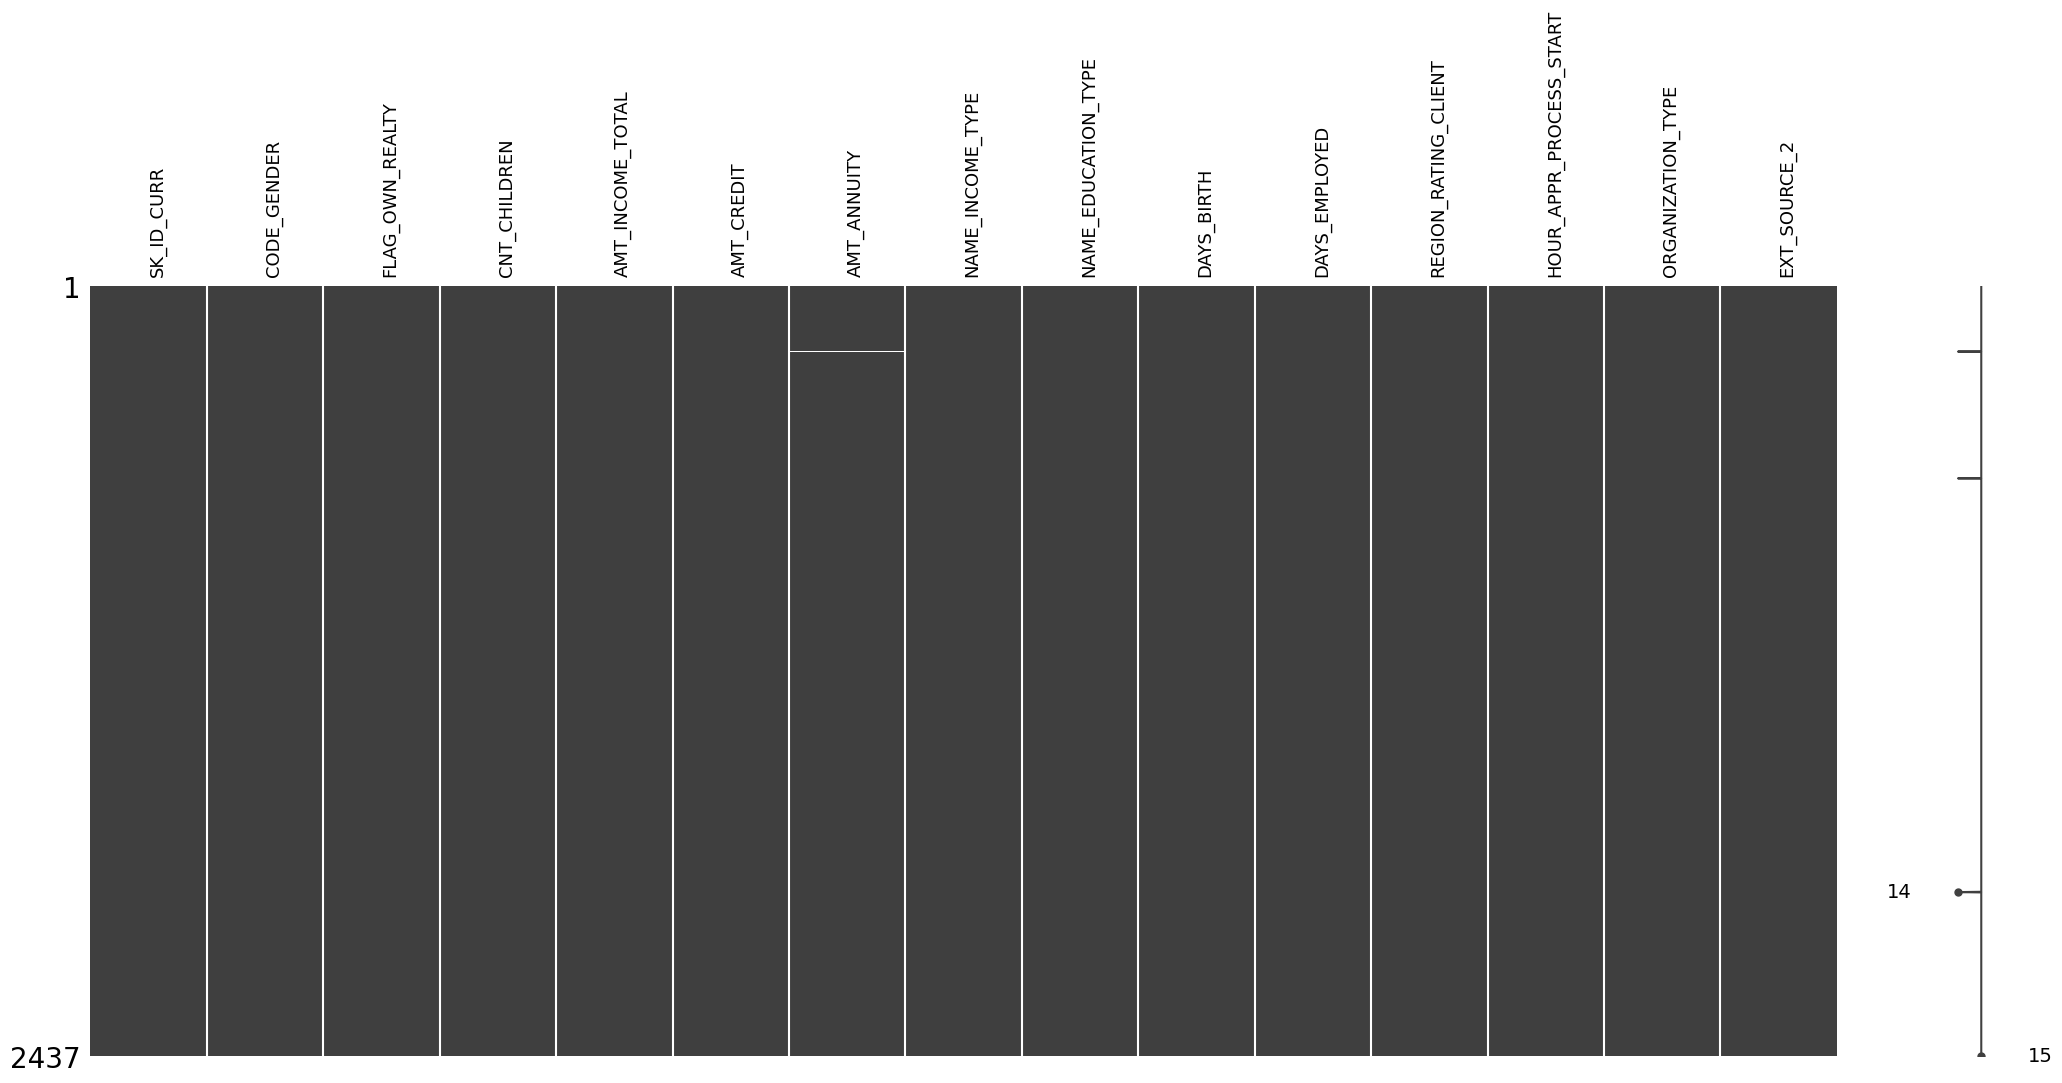

In [ ]:
clean.vm(df,0.05,'/content/P7_NA/P7_NA_100a.png')

In [ ]:
len(df['SK_ID_CURR'].unique().tolist())
#Il y a bien une ligne pour chaque client ID, vérification plus rigoureuse avec la recherche de doublon plus loin.

48744

Base de données de 307 511 clients.

In [ ]:
clean.info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SK_ID_CURR               48744 non-null  object 
 1   CODE_GENDER              48744 non-null  object 
 2   FLAG_OWN_REALTY          48744 non-null  object 
 3   CNT_CHILDREN             48744 non-null  int64  
 4   AMT_INCOME_TOTAL         48744 non-null  float64
 5   AMT_CREDIT               48744 non-null  float64
 6   AMT_ANNUITY              48720 non-null  float64
 7   NAME_INCOME_TYPE         48744 non-null  object 
 8   NAME_EDUCATION_TYPE      48744 non-null  object 
 9   DAYS_BIRTH               48744 non-null  int64  
 10  DAYS_EMPLOYED            48744 non-null  int64  
 11  REGION_RATING_CLIENT     48744 non-null  int64  
 12  HOUR_APPR_PROCESS_START  48744 non-null  int64  
 13  ORGANIZATION_TYPE        48744 non-null  object 
 14  EXT_SOURCE_2          

In [ ]:
df.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_2
0,100001,F,Y,0,135000.0,568800.0,20560.5,Working,Higher education,-19241,-2329,2,18,Kindergarten,0.789654
1,100005,M,Y,0,99000.0,222768.0,17370.0,Working,Secondary / secondary special,-18064,-4469,2,9,Self-employed,0.291656
2,100013,M,Y,0,202500.0,663264.0,69777.0,Working,Higher education,-20038,-4458,2,14,Transport: type 3,0.699787
3,100028,F,Y,2,315000.0,1575000.0,49018.5,Working,Secondary / secondary special,-13976,-1866,2,11,Business Entity Type 3,0.509677
4,100038,M,N,1,180000.0,625500.0,32067.0,Working,Secondary / secondary special,-13040,-2191,2,5,Business Entity Type 3,0.425687


In [ ]:
df['HOUR_APPR_PROCESS_START'].unique()

array([18,  9, 14, 11,  5, 15,  7, 17, 10, 12, 13,  8,  4, 19, 16,  3,  6,
        2, 23, 20, 21, 22,  1,  0])

## <a name="C12"> 1.2 Fonction **application**  </a>

In [ ]:
def application(chemin, selected_features):
  df = pd.read_csv(chemin,
              usecols= selected_features,
              dtype={'SK_ID_CURR' : 'object',
                     #'TARGET' :  'object'
                      })
  # AGE
  df['DAYS_BIRTH'] = round(((df['DAYS_BIRTH']*(-1))/30)/12)
  df['DAYS_BIRTH'] = df['DAYS_BIRTH'].astype(int)
  # ANCIENNETE EMPLOI
  df['DAYS_EMPLOYED'] = round(((df['DAYS_EMPLOYED']*(-1))/30)/12)
  df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].astype(int)
  # RATIO D'ENDETTEMENT
  df['RATIO_ENDETT(%)'] = round((df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'])*100,1)
  # SECTEUR
  organization_categories = {
    'Business Entity Type 3': 'Business Entity',
    'School': 'Education',
    'Government': 'Government and Public Services',
    'Religion': 'Other Categories',
    'Other': 'Other Categories',
    'XNA': 'Inactive',
    'Electricity': 'Utilities and Services',
    'Medicine': 'Healthcare and Medicine',
    'Business Entity Type 2': 'Business Entity',
    'Self-employed': 'Self-Employed and Professional Services',
    'Transport: type 2': 'Other Categories',
    'Construction': 'Other Categories',
    'Housing': 'Utilities and Services',
    'Kindergarten': 'Education',
    'Trade: type 7': 'Industry and Trade',
    'Industry: type 11': 'Industry and Trade',
    'Military': 'Government and Public Services',
    'Services': 'Other Categories',
    'Security Ministries': 'Government and Public Services',
    'Transport: type 4': 'Other Categories',
    'Industry: type 1': 'Industry and Trade',
    'Emergency': 'Government and Public Services',
    'Security': 'Government and Public Services',
    'Trade: type 2': 'Industry and Trade',
    'University': 'Education',
    'Transport: type 3': 'Other Categories',
    'Police': 'Government and Public Services',
    'Business Entity Type 1': 'Business Entity',
    'Postal': 'Government and Public Services',
    'Industry: type 4': 'Industry and Trade',
    'Agriculture': 'Other Categories',
    'Restaurant': 'Hospitality and Entertainment',
    'Culture': 'Hospitality and Entertainment',
    'Hotel': 'Hospitality and Entertainment',
    'Industry: type 7': 'Industry and Trade',
    'Trade: type 3': 'Industry and Trade',
    'Industry: type 3': 'Industry and Trade',
    'Bank': 'Financial and Insurance',
    'Industry: type 9': 'Industry and Trade',
    'Insurance': 'Financial and Insurance',
    'Trade: type 6': 'Industry and Trade',
    'Industry: type 2': 'Industry and Trade',
    'Transport: type 1': 'Other Categories',
    'Industry: type 12': 'Industry and Trade',
    'Mobile': 'Utilities and Services',
    'Trade: type 1': 'Industry and Trade',
    'Industry: type 5': 'Industry and Trade',
    'Industry: type 10': 'Industry and Trade',
    'Legal Services': 'Self-Employed and Professional Services',
    'Advertising': 'Hospitality and Entertainment',
    'Trade: type 5': 'Industry and Trade',
    'Cleaning': 'Utilities and Services',
    'Industry: type 13': 'Industry and Trade',
    'Trade: type 4': 'Industry and Trade',
    'Telecom': 'Utilities and Services',
    'Industry: type 8': 'Industry and Trade',
    'Realtor': 'Self-Employed and Professional Services',
    'Industry: type 6': 'Industry and Trade'}
  df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(organization_categories)
  # Niveau étude
  education_mapping = {
    'Secondary / secondary special': 'BAC',
    'Higher education': 'ENS_SUP',
    'Incomplete higher': 'BAC',
    'Lower secondary': 'COLLEGE',
    'Academic degree': 'ENS_SUP'}
  df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map(education_mapping)

  #Renommer
  df = df.rename(columns={'DAYS_BIRTH': 'AGE',
                          'DAYS_EMPLOYED' : 'ANCIENNETE_EMPLOI',
                          'ORGANIZATION_TYPE' : 'SECTEUR_ACTIVITE',
                          'NAME_EDUCATION_TYPE' : 'NIVEAU_ETUDE',
                          'NAME_INCOME_TYPE' : 'OCCUPATION',
                          'HOUR_APPR_PROCESS_START' : 'HEURE_APP',
                          'EXT_SOURCE_2' : 'SCORE_2_EXT',
                          'CODE_GENDER' : 'GENRE',
                          'FLAG_OWN_REALTY' : 'PROPRIETAIRE',
                          'CNT_CHILDREN' : 'NBRE_ENFANT',
                          'AMT_INCOME_TOTAL': 'REVENUS_TOT',
                          'AMT_CREDIT' : 'MONTANT_CREDIT',
                          'AMT_ANNUITY' : 'REMB_ANNUEL',
                          'REGION_RATING_CLIENT' : 'SCORE_REGION'
                          })
  return df


In [ ]:
chemin = '/content/application_test.csv' #'/content/application_train.csv'
df = application(chemin, sel_features_application)

In [ ]:
df.head()

,SK_ID_CURR,GENRE,PROPRIETAIRE,NBRE_ENFANT,REVENUS_TOT,MONTANT_CREDIT,REMB_ANNUEL,OCCUPATION,NIVEAU_ETUDE,AGE,ANCIENNETE_EMPLOI,SCORE_REGION,HEURE_APP,SECTEUR_ACTIVITE,SCORE_2_EXT,RATIO_ENDETT(%)
0,100001,F,Y,0,135000.0,568800.0,20560.5,Working,ENS_SUP,53,6,2,18,Education,0.789654,15.2
1,100005,M,Y,0,99000.0,222768.0,17370.0,Working,BAC,50,12,2,9,Self-Employed and Professional Services,0.291656,17.5
2,100013,M,Y,0,202500.0,663264.0,69777.0,Working,ENS_SUP,56,12,2,14,Other Categories,0.699787,34.5
3,100028,F,Y,2,315000.0,1575000.0,49018.5,Working,BAC,39,5,2,11,Business Entity,0.509677,15.6
4,100038,M,N,1,180000.0,625500.0,32067.0,Working,BAC,36,6,2,5,Business Entity,0.425687,17.8


In [ ]:
df['SECTEUR_ACTIVITE'].unique()

array(['Education', 'Self-Employed and Professional Services',
       'Other Categories', 'Business Entity',
       'Government and Public Services', 'Industry and Trade', 'Inactive',
       'Financial and Insurance', 'Healthcare and Medicine',
       'Utilities and Services', 'Hospitality and Entertainment'],
      dtype=object)

In [ ]:
df.to_csv('/content/P7_NA/df_test_set_1.csv', index=False)

# <a name=C2> 2. Table credit_card_balance.csv <a>

## <a name="C21"> 2.1 Visualisation </a>

In [ ]:
sel_features_credit = ['SK_ID_CURR',
                     'SK_ID_PREV',
                     "MONTHS_BALANCE",
                     "AMT_BALANCE",
                     "AMT_CREDIT_LIMIT_ACTUAL",
                     "AMT_INST_MIN_REGULARITY",
                     #"AMT_RECEIVABLE_PRINCIPAL",
                     #"AMT_TOTAL_RECEIVABLE",
                     "CNT_DRAWINGS_CURRENT",
                     "NAME_CONTRACT_STATUS",
                       'AMT_DRAWINGS_CURRENT',
                      #'SK_DPD',
                       'SK_DPD_DEF',
                     "AMT_PAYMENT_TOTAL_CURRENT"]

credit_card = pd.read_csv('/content/credit_card_balance.csv',
                          usecols= sel_features_credit,
                          dtype={'SK_ID_CURR' : 'object',
                                 'SK_ID_PREV' : 'object',
                      })

In [ ]:
clean.info(credit_card)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 12 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   SK_ID_PREV                 object 
 1   SK_ID_CURR                 object 
 2   MONTHS_BALANCE             int64  
 3   AMT_BALANCE                float64
 4   AMT_CREDIT_LIMIT_ACTUAL    int64  
 5   AMT_DRAWINGS_CURRENT       float64
 6   AMT_INST_MIN_REGULARITY    float64
 7   AMT_PAYMENT_TOTAL_CURRENT  float64
 8   CNT_DRAWINGS_CURRENT       int64  
 9   NAME_CONTRACT_STATUS       object 
 10  SK_DPD                     int64  
 11  SK_DPD_DEF                 int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 351.6+ MB
None
       MONTHS_BALANCE   AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
count    3.840312e+06  3.840312e+06             3.840312e+06   
mean    -3.452192e+01  5.830016e+04             1.538080e+05   
std      2.666775e+01  1.063070e+05             1.651457e+05   
mi

SK_ID_PREV                   0.000000
SK_ID_CURR                   0.000000
MONTHS_BALANCE               0.000000
AMT_BALANCE                  0.000000
AMT_CREDIT_LIMIT_ACTUAL      0.000000
AMT_DRAWINGS_CURRENT         0.000000
AMT_INST_MIN_REGULARITY      0.079482
AMT_PAYMENT_TOTAL_CURRENT    0.000000
AMT_TOTAL_RECEIVABLE         0.000000
CNT_DRAWINGS_CURRENT         0.000000
NAME_CONTRACT_STATUS         0.000000
SK_DPD                       0.000000
SK_DPD_DEF                   0.000000
dtype: float64

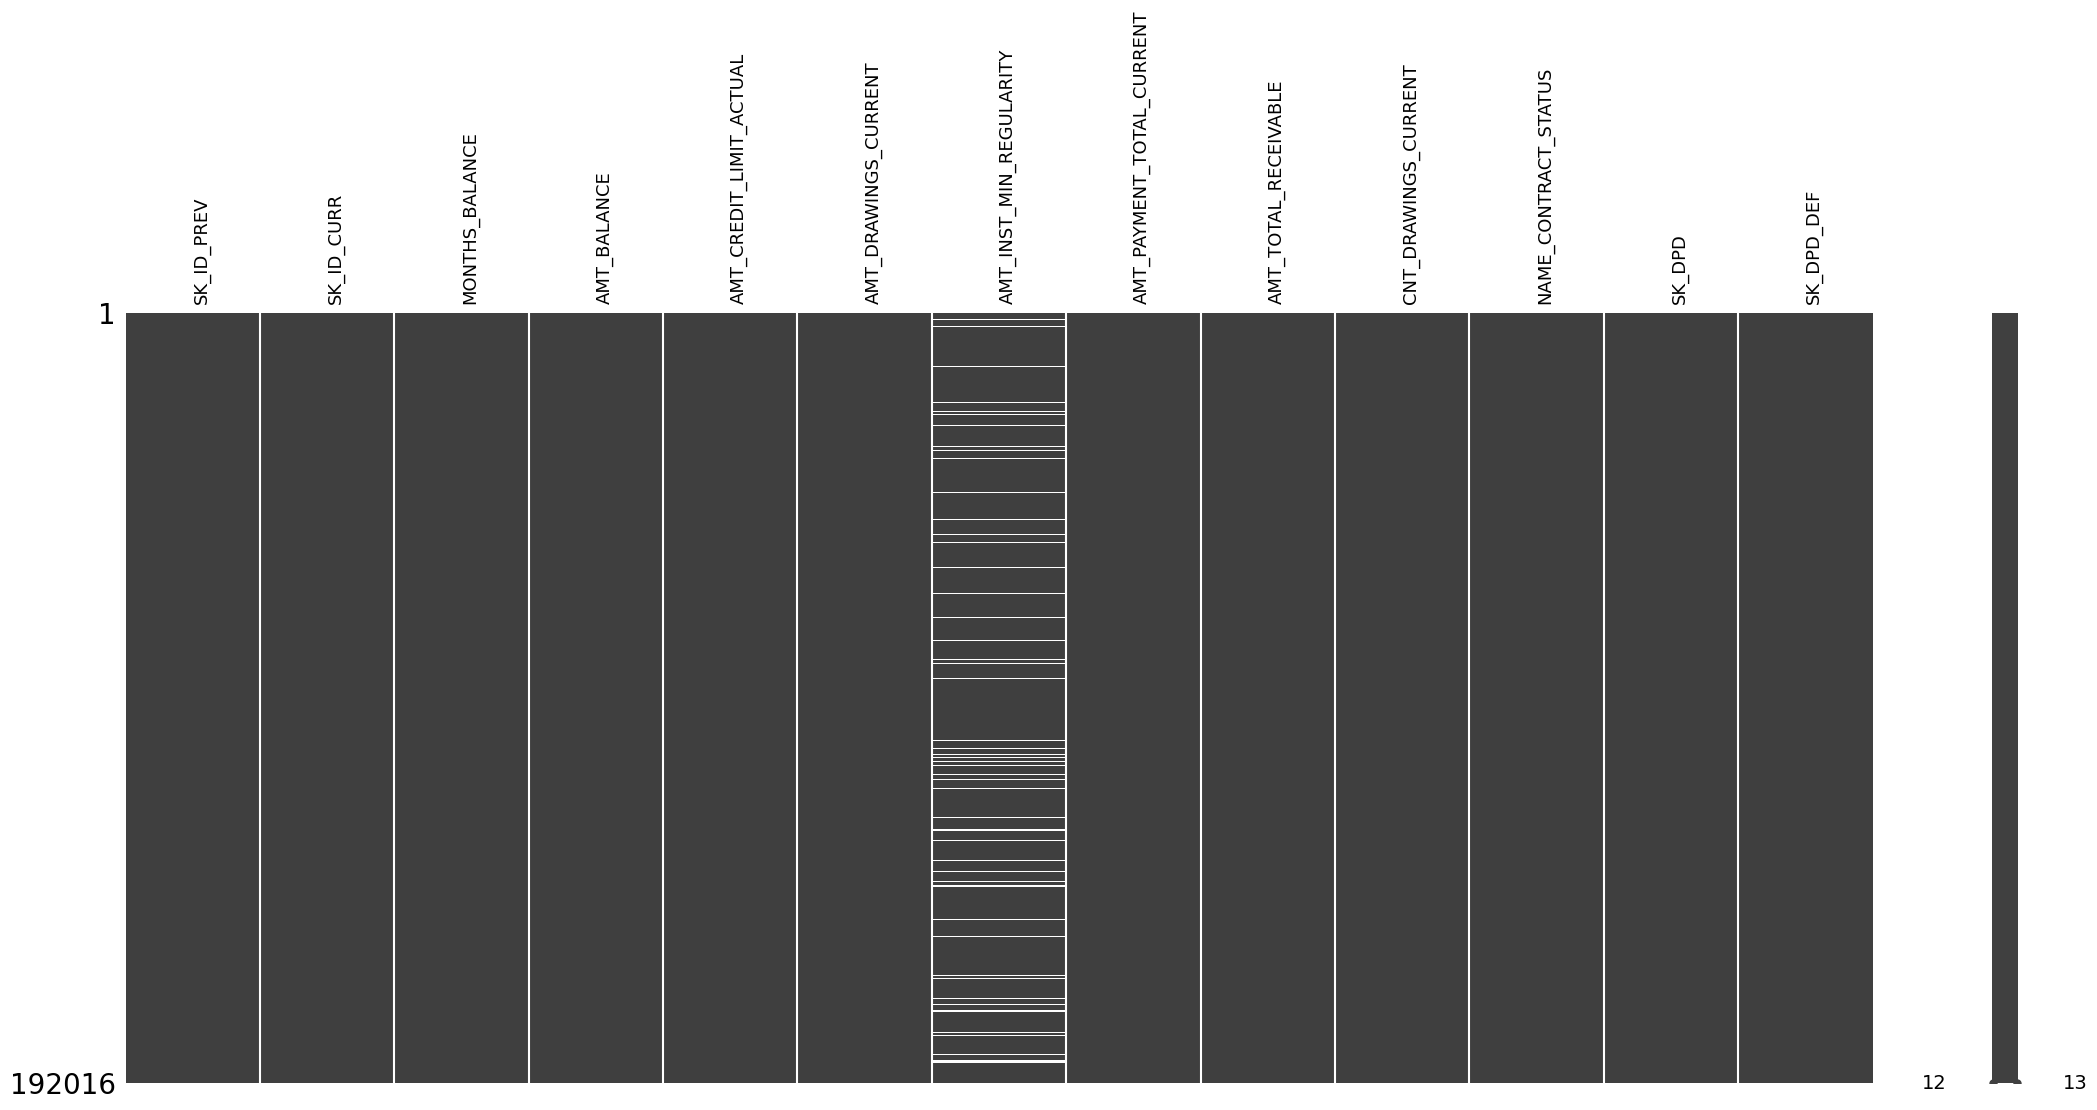

In [ ]:
clean.vm(credit_card,0.05,'/content/P7_NA/P7_NA_200.png')

In [ ]:
credit_card['NAME_CONTRACT_STATUS'].unique()

array(['Active', 'Completed', 'Demand', 'Signed', 'Sent proposal',
       'Refused', 'Approved'], dtype=object)

In [ ]:
credit_card.loc[credit_card['NAME_CONTRACT_STATUS'] != 'Active', 'NAME_CONTRACT_STATUS'] = 'Inactif'

In [ ]:
credit_card.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()

SK_ID_CURR
100006    1
100011    1
100013    1
100021    1
100023    1
         ..
456244    1
456246    1
456247    1
456248    1
456250    1
Name: SK_ID_PREV, Length: 103558, dtype: int64

In [ ]:
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder

def encoder_one_hot(df):
  cat_features = df.dtypes[df.dtypes == 'object'].index.tolist()
  cat_features.remove('SK_ID_CURR')
  cat_features.remove('SK_ID_PREV')
  # Create a ColumnTransformer with OneHotEncoder
  OneHot_transformer = OneHotEncoder(use_cat_names= True)
  column_trans = ColumnTransformer(
    transformers=[
        ('oneHot', OneHot_transformer, cat_features)
    ],remainder='passthrough')
  ct = column_trans.fit(df)
  ct.set_output(transform="pandas")
  transformed_data = column_trans.transform(df)
  #transformed_df = pd.DataFrame(transformed_data)
  return transformed_data


In [ ]:
test = encoder_one_hot(credit_card[15:25])
test.drop(['remainder__SK_ID_PREV'], axis= 1, inplace = True)
test2 = test.groupby('remainder__SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var', 'count'])

oneHot__NAME_CONTRACT_STATUS_Active                   \
                                                      min max mean sum var   
remainder__SK_ID_CURR                                                        
105755                                                  1   1  1.0   1 NaN   
132481                                                  1   1  1.0   1 NaN   
217113                                                  1   1  1.0   1 NaN   
231608                                                  1   1  1.0   1 NaN   
255981                                                  1   1  1.0   1 NaN   
259807                                                  1   1  1.0   1 NaN   
276642                                                  0   0  0.0   0 NaN   
289902                                                  1   1  1.0   1 NaN   
302450                                                  0   0  0.0   0 NaN   
323730                                                  1   1  1.0   1 NaN   

                            oneHot__NAME_CONTRACT_STATUS_Inactif               \
                      count                                  min max mean sum   
remainder__SK_ID_CURR                                                           
105755                    1                                    0   0  0.0   0   
132481                    1                                    0   0  0.0   0   
217113                    1                                    0   0  0.0   0   
231608                    1                                    0   0  0.0   0   
255981                    1                                    0   0  0.0   0   
259807                    1                                    0   0  0.0   0   
276642                    1                                    1   1  1.0   1   
289902                    1                                    0   0  0.0   0   
302450                    1                                    1   1  1.0   1   
323730                    1                                    0   0  0.0   0   

                       ... remainder__SK_DPD                \
                       ...              mean sum var count   
remainder__SK_ID_CURR  ...                                   
105755                 ...               0.0   0 NaN     1   
132481                 ...               0.0   0 NaN     1   
217113                 ...               0.0   0 NaN     1   
231608                 ...               0.0   0 NaN     1   
255981                 ...               0.0   0 NaN     1   
259807                 ...               0.0   0 NaN     1   
276642                 ...               0.0   0 NaN     1   
289902                 ...               0.0   0 NaN     1   
302450                 ...               0.0   0 NaN     1   
323730                 ...               0.0   0 NaN     1   

                      remainder__SK_DPD_DEF                         
                                        min max mean sum var count  
remainder__SK_ID_CURR                                               
105755                                    0   0  0.0   0 NaN     1  
132481                                    0   0  0.0   0 NaN     1  
217113                                    0   0  0.0   0 NaN     1  
231608                                    0   0  0.0   0 NaN     1  
255981                                    0   0  0.0   0 NaN     1  
259807                                    0   0  0.0   0 NaN     1  
276642                                    0   0  0.0   0 NaN     1  
289902                                    0   0  0.0   0 NaN     1  
302450                                    0   0  0.0   0 NaN     1  
323730                                    0   0  0.0   0 NaN     1  

[10 rows x 66 columns]

In [ ]:
test2.reset_index()

remainder__SK_ID_CURR oneHot__NAME_CONTRACT_STATUS_Active                   \
                                                        min max mean sum var   
0                105755                                   1   1  1.0   1 NaN   
1                132481                                   1   1  1.0   1 NaN   
2                217113                                   1   1  1.0   1 NaN   
3                231608                                   1   1  1.0   1 NaN   
4                255981                                   1   1  1.0   1 NaN   
5                259807                                   1   1  1.0   1 NaN   
6                276642                                   0   0  0.0   0 NaN   
7                289902                                   1   1  1.0   1 NaN   
8                302450                                   0   0  0.0   0 NaN   
9                323730                                   1   1  1.0   1 NaN   

        oneHot__NAME_CONTRACT_STATUS_Inactif           ... remainder__SK_DPD  \
  count                                  min max mean  ...              mean   
0     1                                    0   0  0.0  ...               0.0   
1     1                                    0   0  0.0  ...               0.0   
2     1                                    0   0  0.0  ...               0.0   
3     1                                    0   0  0.0  ...               0.0   
4     1                                    0   0  0.0  ...               0.0   
5     1                                    0   0  0.0  ...               0.0   
6     1                                    1   1  1.0  ...               0.0   
7     1                                    0   0  0.0  ...               0.0   
8     1                                    1   1  1.0  ...               0.0   
9     1                                    0   0  0.0  ...               0.0   

                remainder__SK_DPD_DEF                         
  sum var count                   min max mean sum var count  
0   0 NaN     1                     0   0  0.0   0 NaN     1  
1   0 NaN     1                     0   0  0.0   0 NaN     1  
2   0 NaN     1                     0   0  0.0   0 NaN     1  
3   0 NaN     1                     0   0  0.0   0 NaN     1  
4   0 NaN     1                     0   0  0.0   0 NaN     1  
5   0 NaN     1                     0   0  0.0   0 NaN     1  
6   0 NaN     1                     0   0  0.0   0 NaN     1  
7   0 NaN     1                     0   0  0.0   0 NaN     1  
8   0 NaN     1                     0   0  0.0   0 NaN     1  
9   0 NaN     1                     0   0  0.0   0 NaN     1  

[10 rows x 67 columns]

In [ ]:
test.head()

,oneHot__SK_ID_PREV_2037377,oneHot__SK_ID_PREV_1816636,oneHot__SK_ID_PREV_1039039,oneHot__SK_ID_PREV_2016842,oneHot__SK_ID_PREV_1189095,oneHot__SK_ID_PREV_1104090,oneHot__SK_ID_PREV_1683604,oneHot__SK_ID_PREV_2392920,oneHot__SK_ID_PREV_2021411,oneHot__SK_ID_PREV_1927949,...,remainder__SK_ID_CURR,remainder__MONTHS_BALANCE,remainder__AMT_BALANCE,remainder__AMT_CREDIT_LIMIT_ACTUAL,remainder__AMT_DRAWINGS_CURRENT,remainder__AMT_INST_MIN_REGULARITY,remainder__AMT_PAYMENT_TOTAL_CURRENT,remainder__CNT_DRAWINGS_CURRENT,remainder__SK_DPD,remainder__SK_DPD_DEF
15,1,0,0,0,0,0,0,0,0,0,...,289902,-1,131294.340,135000,0.0,6774.660,6975.0,0,0,0
16,0,1,0,0,0,0,0,0,0,0,...,255981,-6,72899.955,450000,67500.0,2457.720,25200.0,1,0,0
17,0,0,1,0,0,0,0,0,0,0,...,276642,-6,0.000,67500,0.0,0.000,0.0,0,0,0
18,0,0,0,1,0,0,0,0,0,0,...,302450,-3,0.000,0,0.0,0.000,0.0,0,0,0
19,0,0,0,0,1,0,0,0,0,0,...,231608,-4,452774.700,450000,9000.0,22916.475,27000.0,1,0,0


In [ ]:
test

,oneHot__NAME_CONTRACT_STATUS_Active,oneHot__NAME_CONTRACT_STATUS_Inactif,remainder__SK_ID_CURR,remainder__MONTHS_BALANCE,remainder__AMT_BALANCE,remainder__AMT_CREDIT_LIMIT_ACTUAL,remainder__AMT_DRAWINGS_CURRENT,remainder__AMT_INST_MIN_REGULARITY,remainder__AMT_PAYMENT_TOTAL_CURRENT,remainder__AMT_RECEIVABLE_PRINCIPAL,remainder__AMT_TOTAL_RECEIVABLE,remainder__CNT_DRAWINGS_CURRENT,remainder__SK_DPD,remainder__SK_DPD_DEF
15,1,0,289902,-1,131294.340,135000,0.000,6774.660,6975.00,128518.020,131294.340,0,0,0
16,1,0,255981,-6,72899.955,450000,67500.000,2457.720,25200.00,68954.805,71554.455,1,0,0
17,0,1,276642,-6,0.000,67500,0.000,0.000,0.00,0.000,0.000,0,0,0
18,0,1,302450,-3,0.000,0,0.000,0.000,0.00,0.000,0.000,0,0,0
19,1,0,231608,-4,452774.700,450000,9000.000,22916.475,27000.00,440329.050,451429.200,1,0,0
20,1,0,259807,-6,45413.730,45000,105750.000,1471.005,84637.98,43650.855,44068.230,3,0,0
21,1,0,217113,-1,68710.140,67500,4412.250,3315.240,3375.00,67341.870,68710.140,4,0,0
22,1,0,132481,-1,85792.095,135000,63337.815,2250.000,18521.55,85086.945,85792.095,9,0,0
23,1,0,105755,-5,464452.470,450000,279112.500,8921.970,9000.00,448552.125,456379.470,7,0,0
24,1,0,323730,-3,152801.550,157500,0.000,7875.000,7875.00,146857.995,152801.550,0,0,0


In [ ]:
credit_card[credit_card['AMT_INST_MIN_REGULARITY'].isna()].describe()

In [ ]:
credit_card[credit_card['AMT_INST_MIN_REGULARITY'].isna()]

In [ ]:
credit_card[credit_card['SK_ID_PREV'] == '2552584']
## Les valeurs manquantes de la variable AMT_INST_MIN_REGULARITY sont logiques
## S'il n'y a pas de montant positif dans l'AMT_BALANCE, il n'ya rien à rembourser et donc aucun seuil de paiement minimum
## J'ilmpute ses valeurs par zéros.
## 0.07% des lignes sont concernées

In [ ]:
credit_card['AMT_INST_MIN_REGULARITY'] = credit_card['AMT_INST_MIN_REGULARITY'].fillna(0)

In [ ]:
credit_card[credit_card['NAME_CONTRACT_STATUS'] != 'Active']

In [ ]:
sns.set()
sns.countplot(data= credit_card[credit_card['NAME_CONTRACT_STATUS'] != 'Active'],
              y = 'NAME_CONTRACT_STATUS')

#La plupart des contrat inactif sont dit "completed".

##   <a name=C22> 2.2 Fonction **credit_card** <a>

In [ ]:
def credit_card_fonct(chemin, selected_features,df_application):
  df_credit_card = pd.read_csv(chemin,
                          usecols= selected_features,
                          dtype={'SK_ID_CURR' : 'object',
                                 'SK_ID_PREV' : 'object',})
  # Intersection de la table application et la table credit_card (pour effectuer les traitement uniquement sur les individus concernés)
  df_credit_card = df_credit_card.merge(df_application['SK_ID_CURR'], how = 'inner', on = 'SK_ID_CURR')
  df_credit_card.loc[df_credit_card['NAME_CONTRACT_STATUS'] != 'Active', 'NAME_CONTRACT_STATUS'] = 'Inactif'

  #
  df_credit_card['AMT_INST_MIN_REGULARITY'] = df_credit_card['AMT_INST_MIN_REGULARITY'].fillna(0)

  #Compte des lignes de crédit---------------------------------------------------------------------------
  count_cc = df_credit_card.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
  count_cc = count_cc.reset_index()
  count_cc = count_cc.rename(columns = {'SK_ID_PREV' : 'N1BRE_CONTRAT'})
  print(count_cc)
  #Compte des lignes de crédits inactives-----------------------------------------------------------------
  cc_inactif = df_credit_card[df_credit_card['NAME_CONTRACT_STATUS'] != 'Active']
  count_cc_inactif = cc_inactif.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
  count_cc_inactif = count_cc_inactif.reset_index()
  count_cc_inactif = count_cc_inactif.rename(columns = {'SK_ID_PREV' :'N2BRE_CONTRAT_INACTIFS'})
  print(count_cc_inactif)
  # General aggregations----------------------------------------------------------------------------------
  df_credit_card.drop(['SK_ID_PREV'], axis= 1, inplace = True)
  df_cc_agg = df_credit_card.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var', 'count']).reset_index()
  del df_credit_card
  df_cc_agg = df_cc_agg.merge(count_cc, how = 'left', on ='SK_ID_CURR')
  df_cc_agg = df_cc_agg.merge(count_cc_inactif, how = 'left', on ='SK_ID_CURR')
  df_cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in df_cc_agg.columns.tolist()])
  listcol = df_cc_agg.columns
  # Choix des features -------------------------------------------------------------------------------------
  df_cc_agg = df_cc_agg[['CC_S_K', 'CC_MONTHS_BALANCE_MIN', 'CC_MONTHS_BALANCE_MAX',
                 'CC_AMT_BALANCE_MEAN', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN',
                 'CC_AMT_DRAWINGS_CURRENT_MEAN', 'CC_AMT_INST_MIN_REGULARITY_MEAN',
                 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN', 'CC_CNT_DRAWINGS_CURRENT_MEAN',
                 'CC_SK_DPD_DEF_MEAN', 'CC_N_1', 'CC_N_2'
                 ]]
  df_cc_agg = df_cc_agg.rename(columns= { 'CC_S_K' : 'SK_ID_CURR',
                                         'CC_MONTHS_BALANCE_MIN': 'CC_ANCIENNETE_MOIS',
                                          'CC_MONTHS_BALANCE_MAX': 'CC_RECENCE_MOIS',
                                          'CC_AMT_BALANCE_MEAN': 'CC_SOLDE_MOYEN_MENSUEL',
                                          'CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN': 'CC_LIMITE_CREDIT_MOYENNE',
                                          'CC_AMT_DRAWINGS_CURRENT_MEAN': 'CC_MONTANT_RETRAIT_MOYEN',
                                          'CC_AMT_INST_MIN_REGULARITY_MEAN': 'CC_MIN_REMBOURSEMENT_MOYEN',
                                          'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN': 'CC_PAIEMENT_TOTAL_MOYEN',
                                          'CC_CNT_DRAWINGS_CURRENT_MEAN': 'CC_NOMBRE_RETRAIT_MOYEN',
                                          'CC_SK_DPD_DEF_MEAN': 'CC_J_RETARD_MOYEN',
                                          'CC_N_1' : 'CC_NBRE_CONTRAT_TOTAL', 'CC_N_2': 'CC_NBRE_CONTRAT_INACTIF'})
  df_cc_agg[['CC_ANCIENNETE_MOIS', 'CC_RECENCE_MOIS']] = df_cc_agg[['CC_ANCIENNETE_MOIS', 'CC_RECENCE_MOIS']]*(-1)
  df_cc_agg['CC_NBRE_CONTRAT_INACTIF'] = df_cc_agg['CC_NBRE_CONTRAT_INACTIF'].fillna(0)
  df_cc_agg['CC_NBRE_CONTRAT_INACTIF'] = df_cc_agg['CC_NBRE_CONTRAT_INACTIF'].astype(int)
  return df_cc_agg, listcol

In [ ]:
del credit_card

In [ ]:
sel_features_credit = ['SK_ID_CURR',
                     'SK_ID_PREV',
                     "MONTHS_BALANCE",
                     "AMT_BALANCE",
                     "AMT_CREDIT_LIMIT_ACTUAL",
                     "AMT_INST_MIN_REGULARITY",
                     #"AMT_RECEIVABLE_PRINCIPAL",
                     #"AMT_TOTAL_RECEIVABLE",
                     "CNT_DRAWINGS_CURRENT",
                     "NAME_CONTRACT_STATUS",
                       'AMT_DRAWINGS_CURRENT',
                      #'SK_DPD',
                       'SK_DPD_DEF',
                     "AMT_PAYMENT_TOTAL_CURRENT"]

In [ ]:
cc_agg, lscol = credit_card_fonct('/content/credit_card_balance.csv', sel_features_credit, df)

      SK_ID_CURR  N1BRE_CONTRAT
0         100013              1
1         100028              1
2         100042              1
3         100066              1
4         100067              1
...          ...            ...
16648     456115              1
16649     456119              1
16650     456168              1
16651     456189              1
16652     456250              1

[16653 rows x 2 columns]
     SK_ID_CURR  N2BRE_CONTRAT_INACTIFS
0        100109                       1
1        100128                       1
2        100170                       1
3        100187                       1
4        100386                       1
...         ...                     ...
3148     455513                       1
3149     455694                       1
3150     455751                       1
3151     455955                       1
3152     456010                       1

[3153 rows x 2 columns]


In [ ]:
lscol

Index(['CC_S_K', 'CC_SK_ID_CURR_', 'CC_MONTHS_BALANCE_MIN',
       'CC_MONTHS_BALANCE_MAX', 'CC_MONTHS_BALANCE_MEAN',
       'CC_MONTHS_BALANCE_SUM', 'CC_MONTHS_BALANCE_VAR',
       'CC_MONTHS_BALANCE_COUNT', 'CC_AMT_BALANCE_MIN', 'CC_AMT_BALANCE_MAX',
       'CC_AMT_BALANCE_MEAN', 'CC_AMT_BALANCE_SUM', 'CC_AMT_BALANCE_VAR',
       'CC_AMT_BALANCE_COUNT', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MIN',
       'CC_AMT_CREDIT_LIMIT_ACTUAL_MAX', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN',
       'CC_AMT_CREDIT_LIMIT_ACTUAL_SUM', 'CC_AMT_CREDIT_LIMIT_ACTUAL_VAR',
       'CC_AMT_CREDIT_LIMIT_ACTUAL_COUNT', 'CC_AMT_DRAWINGS_CURRENT_MIN',
       'CC_AMT_DRAWINGS_CURRENT_MAX', 'CC_AMT_DRAWINGS_CURRENT_MEAN',
       'CC_AMT_DRAWINGS_CURRENT_SUM', 'CC_AMT_DRAWINGS_CURRENT_VAR',
       'CC_AMT_DRAWINGS_CURRENT_COUNT', 'CC_AMT_INST_MIN_REGULARITY_MIN',
       'CC_AMT_INST_MIN_REGULARITY_MAX', 'CC_AMT_INST_MIN_REGULARITY_MEAN',
       'CC_AMT_INST_MIN_REGULARITY_SUM', 'CC_AMT_INST_MIN_REGULARITY_VAR',
       'CC_AMT_INST

In [ ]:
cc_agg.head()

,SK_ID_CURR,CC_ANCIENNETE_MOIS,CC_RECENCE_MOIS,CC_SOLDE_MOYEN_MENSUEL,CC_LIMITE_CREDIT_MOYENNE,CC_MONTANT_RETRAIT_MOYEN,CC_MIN_REMBOURSEMENT_MOYEN,CC_PAIEMENT_TOTAL_MOYEN,CC_NOMBRE_RETRAIT_MOYEN,CC_J_RETARD_MOYEN,CC_NBRE_CONTRAT_TOTAL,CC_NBRE_CONTRAT_INACTIF
0,100013,96,1,18159.919219,131718.75,5953.125000,1348.479375,6817.172344,0.239583,0.010417,1,0
1,100028,49,1,8085.058163,225000.00,6156.400408,5257.169082,5606.152347,2.387755,0.000000,1,0
2,100042,84,1,33356.183036,78750.00,5923.886786,2039.794821,7369.821429,0.380952,0.000000,1,0
3,100066,15,1,0.000000,72600.00,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
4,100067,87,1,27182.729483,45000.00,3237.026897,1612.435345,3688.862069,0.666667,0.034483,1,0


In [ ]:
set_id_credit_card = set(cc_agg['SK_ID_CURR'].unique())
set_id_app = set(df['SK_ID_CURR'].unique())

common_elements = set_id_credit_card.intersection(set_id_app)
len(common_elements)/len(df)

0.34164204825209255

In [ ]:
del set_id_credit_card

28% des clients demandeurs (table application_train, 34% pour la table application_test) ont un contrat de carte de crédit actif ou inactif.

In [ ]:
cc_agg.isna().sum()

SK_ID_CURR                    0
CC_ANCIENNETE_MOIS            0
CC_RECENCE_MOIS               0
CC_SOLDE_MOYEN_MENSUEL        0
CC_LIMITE_CREDIT_MOYENNE      0
CC_MONTANT_RETRAIT_MOYEN      0
CC_MIN_REMBOURSEMENT_MOYEN    0
CC_PAIEMENT_TOTAL_MOYEN       0
CC_NOMBRE_RETRAIT_MOYEN       0
CC_J_RETARD_MOYEN             0
CC_NBRE_CONTRAT_TOTAL         0
CC_NBRE_CONTRAT_INACTIF       0
dtype: int64

In [ ]:
len(cc_agg[cc_agg['CC_NBRE_CONTRAT_INACTIF'] != 0]) / len(cc_agg)

0.16900063287497843

Parmi les clients ayant un historique chez HomeCredit, seuleument 17% ont une ligne de carte de crédit inactive.

In [ ]:
cc_agg.to_csv('/content/P7_NA/credit_card_test_set_1.csv', index=False)

In [ ]:
del cc_agg

# <a name=C3> 3. Table POS_CASH_balance.csv <a>

## <a name="C31"> 3.1 Visualisation </a>

In [ ]:
POS = pd.read_csv('/content/POS_CASH_balance.csv',
                      dtype={'SK_ID_CURR' : 'object',
                             'SK_ID_PREV' : 'object',
                             }
                      )

In [ ]:
clean.info(POS)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             object 
 1   SK_ID_CURR             object 
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 610.4+ MB
None
       MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE        SK_DPD  \
count    1.000136e+07    9.975287e+06           9.975271e+06  1.000136e+07   
mean    -3.501259e+01    1.708965e+01           1.048384e+01  1.160693e+01   
std      2.606657e+01    1.199506e+01           1.110906e+01  1.327140e+02   
min     -9.600000e+01    1.000000e+00           0.000000e+00  0.000000e+00   
25%     -5.400000e+01    1.000000e+01           3.000000e+00  0.000

SK_ID_PREV               0.000000
SK_ID_CURR               0.000000
MONTHS_BALANCE           0.000000
CNT_INSTALMENT           0.002607
CNT_INSTALMENT_FUTURE    0.002608
NAME_CONTRACT_STATUS     0.000000
SK_DPD                   0.000000
SK_DPD_DEF               0.000000
dtype: float64

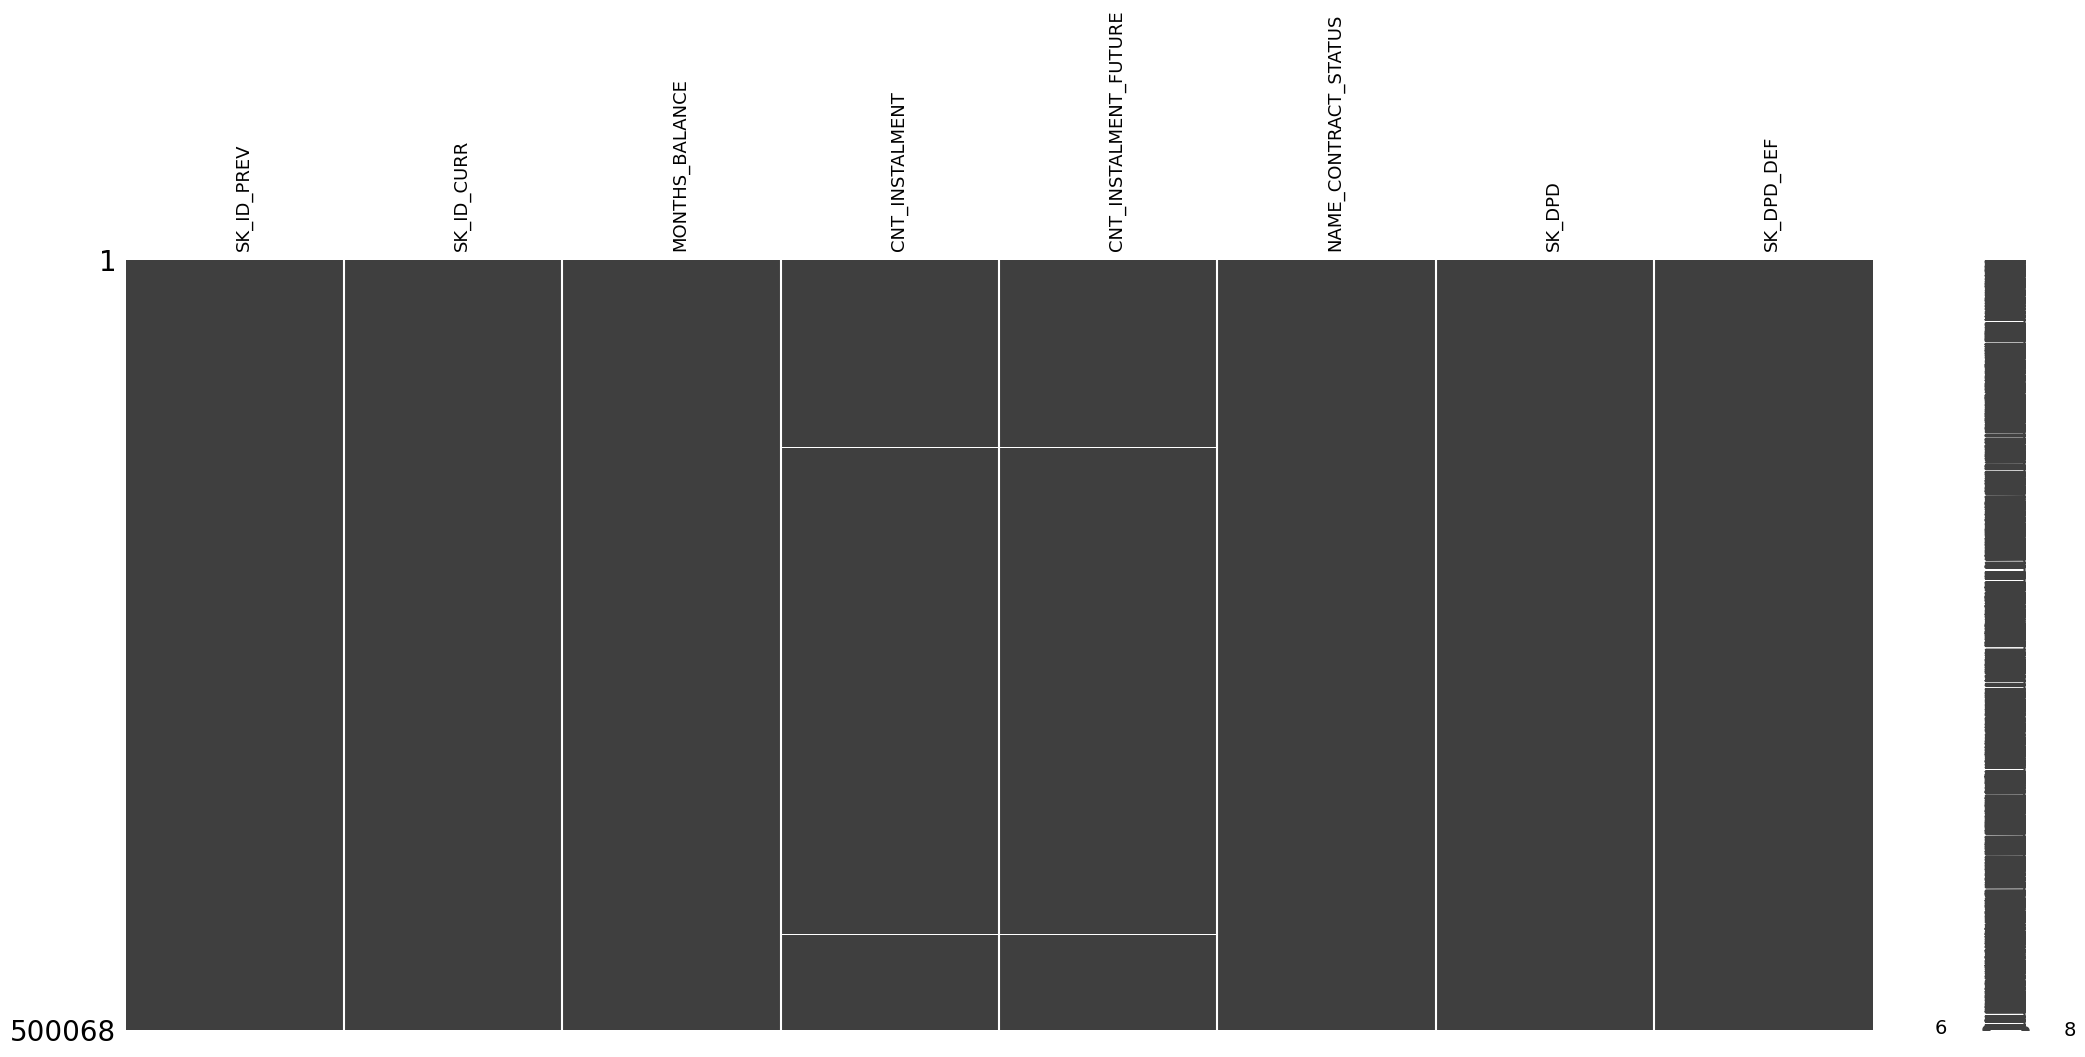

In [ ]:
clean.vm(POS,0.05,'/content/P7_NA/P7_NA_300.png')

In [ ]:
POS['NAME_CONTRACT_STATUS'].unique()

array(['Active', 'Completed', 'Signed', 'Approved',
       'Returned to the store', 'Demand', 'Canceled', 'XNA',
       'Amortized debt'], dtype=object)

In [ ]:
POS[POS['CNT_INSTALMENT'].isna()]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
709,1889585,403422,-6,NaN,NaN,Signed,0,0
759,1618886,382448,-2,NaN,NaN,Signed,0,0
1887,2288203,429576,-6,NaN,NaN,Signed,0,0
1899,2110224,167171,-6,NaN,NaN,Signed,0,0
1910,2031967,235187,-5,NaN,NaN,Signed,0,0
...,...,...,...,...,...,...,...,...
9998668,1770932,441177,-10,NaN,NaN,Signed,0,0
9998696,1770932,441177,-11,NaN,NaN,Signed,0,0
9999114,1770932,441177,-8,NaN,NaN,Signed,0,0
9999116,1770932,441177,-9,NaN,NaN,Signed,0,0


In [ ]:
POS.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
POS[POS['SK_ID_CURR'] == '182943']

## <a name="C32"> 3.2 Fonction **POS**</a>

In [ ]:
def POS_fonct(chemin, df_application):
  df_POS = pd.read_csv(chemin,
                          dtype={'SK_ID_CURR' : 'object',
                                 'SK_ID_PREV' : 'object',})
  # Intersection de la table application et la table credit_card (pour effectuer les traitement uniquement sur les individus concernés)
  df_POS = df_POS.merge(df_application['SK_ID_CURR'], how = 'inner', on = 'SK_ID_CURR')
  df_POS.loc[df_POS['NAME_CONTRACT_STATUS'] != 'Active', 'NAME_CONTRACT_STATUS'] = 'Inactif'

  # Suppression des 0.2% de valeurs manquantes
  df_POS = df_POS[~(df_POS['CNT_INSTALMENT'].isna())]
  #Progession de remboursement
  df_POS['PROGRESS(%)'] = (1- (df_POS['CNT_INSTALMENT_FUTURE']/df_POS['CNT_INSTALMENT']))*100
  progress = df_POS.groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'PROGRESS(%)' : 'max'})
  progress = progress.reset_index()
  progress = progress.groupby('SK_ID_CURR')['PROGRESS(%)'].min()
  progress = progress.reset_index()
  print(progress)
  df_POS = df_POS.drop(columns = ['PROGRESS(%)'])

  #Compte des lignes de crédit---------------------------------------------------------------------------
  count_pos = df_POS.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
  count_pos = count_pos.reset_index()
  count_pos = count_pos.rename(columns = {'SK_ID_PREV' : 'N1BRE_CONTRAT'})
  print(count_pos)
  #Compte des lignes de crédits inactives-----------------------------------------------------------------
  pos_inactif = df_POS[df_POS['NAME_CONTRACT_STATUS'] != 'Active']
  count_pos_inactif = pos_inactif.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
  count_pos_inactif = count_pos_inactif.reset_index()
  count_pos_inactif = count_pos_inactif.rename(columns = {'SK_ID_PREV' :'N2BRE_CONTRAT_INACTIFS'})
  print(count_pos_inactif)

  # General aggregations----------------------------------------------------------------------------------
  df_POS.drop(['SK_ID_PREV'], axis= 1, inplace = True)
  df_pos_agg = df_POS.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var', 'count']).reset_index()
  del df_POS
  df_pos_agg = df_pos_agg.merge(progress, how = 'left', on ='SK_ID_CURR')
  df_pos_agg = df_pos_agg.merge(count_pos, how = 'left', on ='SK_ID_CURR')
  df_pos_agg = df_pos_agg.merge(count_pos_inactif, how = 'left', on ='SK_ID_CURR')
  df_pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in df_pos_agg.columns.tolist()])
  listcol = df_pos_agg.columns
  # Choix des features -------------------------------------------------------------------------------------
  colum_choice = ['POS_S_K','POS_MONTHS_BALANCE_MIN',
                           'POS_MONTHS_BALANCE_MAX',#'POS_CNT_INSTALMENT_MAX',
                           'POS_SK_DPD_DEF_MEAN','POS_N_1','POS_N_2', 'POS_P_R'
                           ]
  df_pos_agg = df_pos_agg[colum_choice]
  df_pos_agg = df_pos_agg.rename(columns= {'POS_S_K' : 'SK_ID_CURR',
                                         'POS_MONTHS_BALANCE_MIN': 'POS_ANCIENNETE_MOIS',
                                          'POS_MONTHS_BALANCE_MAX': 'POS_RECENCE_MOIS',
                                          #'POS_CNT_INSTALMENT_MAX': 'POS_NBRE_INST_MAX',
                                          'POS_SK_DPD_DEF_MEAN': 'POS_J_RETARD_MOYEN',
                                          'POS_N_1' : 'POS_NBRE_CONTRAT_TOTAL',
                                           'POS_N_2': 'POS_NBRE_CONTRAT_INACTIF',
                                           'POS_P_R' : 'POS_PROGRESS_MAX_MIN'})

  df_pos_agg[['POS_ANCIENNETE_MOIS', 'POS_RECENCE_MOIS']] = df_pos_agg[['POS_ANCIENNETE_MOIS', 'POS_RECENCE_MOIS']]*(-1)
  df_pos_agg['POS_NBRE_CONTRAT_INACTIF'] = df_pos_agg['POS_NBRE_CONTRAT_INACTIF'].fillna(0)
  df_pos_agg['POS_NBRE_CONTRAT_INACTIF'] = df_pos_agg['POS_NBRE_CONTRAT_INACTIF'].astype(int)


  return df_pos_agg, listcol

In [ ]:
del POS

In [ ]:
pos_agg, lscol = POS_fonct('/content/POS_CASH_balance.csv',df)

      SK_ID_CURR  PROGRESS(%)
0         100001   100.000000
1         100005   100.000000
2         100013   100.000000
3         100028   100.000000
4         100038   100.000000
...          ...          ...
47799     456221   100.000000
47800     456222    91.666667
47801     456223    10.000000
47802     456224    75.000000
47803     456250    75.000000

[47804 rows x 2 columns]
      SK_ID_CURR  N1BRE_CONTRAT
0         100001              2
1         100005              1
2         100013              3
3         100028              2
4         100038              1
...          ...            ...
47799     456221              1
47800     456222              4
47801     456223              5
47802     456224              2
47803     456250              3

[47804 rows x 2 columns]
      SK_ID_CURR  N2BRE_CONTRAT_INACTIFS
0         100001                       2
1         100005                       1
2         100013                       3
3         100028                       2

In [ ]:
pos_agg.head()

,SK_ID_CURR,POS_ANCIENNETE_MOIS,POS_RECENCE_MOIS,POS_J_RETARD_MOYEN,POS_NBRE_CONTRAT_TOTAL,POS_NBRE_CONTRAT_INACTIF,POS_PROGRESS_MAX_MIN
0,100001,96,53,0.777778,2,2,100.0
1,100005,24,15,0.000000,1,1,100.0
2,100013,66,3,0.000000,3,3,100.0
3,100028,59,20,0.000000,2,2,100.0
4,100038,27,15,0.000000,1,1,100.0


In [ ]:
lscol

Index(['POS_S_K', 'POS_SK_ID_CURR_', 'POS_MONTHS_BALANCE_MIN',
       'POS_MONTHS_BALANCE_MAX', 'POS_MONTHS_BALANCE_MEAN',
       'POS_MONTHS_BALANCE_SUM', 'POS_MONTHS_BALANCE_VAR',
       'POS_MONTHS_BALANCE_COUNT', 'POS_CNT_INSTALMENT_MIN',
       'POS_CNT_INSTALMENT_MAX', 'POS_CNT_INSTALMENT_MEAN',
       'POS_CNT_INSTALMENT_SUM', 'POS_CNT_INSTALMENT_VAR',
       'POS_CNT_INSTALMENT_COUNT', 'POS_CNT_INSTALMENT_FUTURE_MIN',
       'POS_CNT_INSTALMENT_FUTURE_MAX', 'POS_CNT_INSTALMENT_FUTURE_MEAN',
       'POS_CNT_INSTALMENT_FUTURE_SUM', 'POS_CNT_INSTALMENT_FUTURE_VAR',
       'POS_CNT_INSTALMENT_FUTURE_COUNT', 'POS_SK_DPD_MIN', 'POS_SK_DPD_MAX',
       'POS_SK_DPD_MEAN', 'POS_SK_DPD_SUM', 'POS_SK_DPD_VAR',
       'POS_SK_DPD_COUNT', 'POS_SK_DPD_DEF_MIN', 'POS_SK_DPD_DEF_MAX',
       'POS_SK_DPD_DEF_MEAN', 'POS_SK_DPD_DEF_SUM', 'POS_SK_DPD_DEF_VAR',
       'POS_SK_DPD_DEF_COUNT', 'POS_P_R', 'POS_N_1', 'POS_N_2'],
      dtype='object')

In [ ]:
set_id_pos= set(pos_agg['SK_ID_CURR'].unique())
set_id_app = set(df['SK_ID_CURR'].unique())

common_elements = set_id_pos.intersection(set_id_app)
print(len(common_elements)/len(df))
del set_id_pos

0.9807155752502872


94% des clients demandeurs (application_train, 98% pour application_test) ont un historique de prêt de type cash et POS chez Home credit.

In [ ]:
pos_agg.isna().sum()

SK_ID_CURR                  0
POS_ANCIENNETE_MOIS         0
POS_RECENCE_MOIS            0
POS_J_RETARD_MOYEN          0
POS_NBRE_CONTRAT_TOTAL      0
POS_NBRE_CONTRAT_INACTIF    0
POS_PROGRESS_MAX_MIN        0
dtype: int64

Parmi les clients ayant un historique chez HomeCredit, seuleument 17% ont une ligne de carte de crédit inactive.

In [ ]:
pos_agg.to_csv('/content/P7_NA/POS_test_set_1.csv', index=False)

In [ ]:
del pos_agg

In [ ]:
del test
del test2
del common_elements

In [ ]:
del set_id_app



```
set_id_credit_card = set(credit_card['SK_ID_PREV'].unique())
set_id_POS = set(POS['SK_ID_PREV'].unique())

common_elements = set_id_credit_card.intersection(set_id_POS)
len(common_elements)/len(credit_card['SK_ID_PREV'].unique())

----> 0.0
```



Les identifiants SK_ID_PREV sont distincts pour les contrat prêt cash, pret à la consommation ou carte de crédit.

# <a name=C4> 4. Table Installments_payments.csv <a>

## 4.1 Visualisation

In [ ]:
install = pd.read_csv('/content/installments_payments.csv',
                      dtype={'SK_ID_CURR' : 'object',
                             'SK_ID_PREV' : 'object',
                             }
                      )

In [ ]:
install = install.merge(df[['SK_ID_CURR']], how = 'inner', on = 'SK_ID_CURR')
#Je ne garde que les ID propre à la table application_train
#Je réduis mon dataset de 2millions de lignes
install.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,2452854,161674,1.0,21,-546.0,-552.0,11302.605,11302.605
2,1054186,161674,1.0,2,-1300.0,-1307.0,6948.360,6948.360
3,1682318,161674,1.0,2,-240.0,-243.0,7374.510,7374.510
4,2452854,161674,1.0,10,-876.0,-882.0,11302.605,11302.605


In [ ]:
install[install['DAYS_ENTRY_PAYMENT'].str.contains('-') == True]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
9810143,1974125,443903,1.0,11,-1289.0,-1297.0,3743.460,3743.460
9810144,1974125,443903,1.0,7,-1409.0,-1419.0,3743.460,3735.540
9810211,1092599,425393,0.0,91,-440.0,-440.0,2.160,2.160
9810212,2082687,425393,5.0,13,-209.0,-223.0,49088.925,49088.925
9810213,1092599,425393,0.0,10,-2437.0,-2437.0,1578.375,1578.375
...,...,...,...,...,...,...,...,...
10429480,2558851,414528,2.0,1,-505.0,-512.0,154576.080,154576.080
10429481,2088412,448491,1.0,9,-993.0,-995.0,20162.475,20162.475
10429482,2291140,439238,1.0,4,-172.0,-179.0,10392.390,10392.390
10429483,1220366,452934,1.0,5,-2309.0,-2329.0,2069.775,2069.775


SK_ID_PREV                0.00000
SK_ID_CURR                0.00000
NUM_INSTALMENT_VERSION    0.00000
NUM_INSTALMENT_NUMBER     0.00000
DAYS_INSTALMENT           0.00000
DAYS_ENTRY_PAYMENT        0.00021
AMT_INSTALMENT            0.00000
AMT_PAYMENT               0.00021
dtype: float64

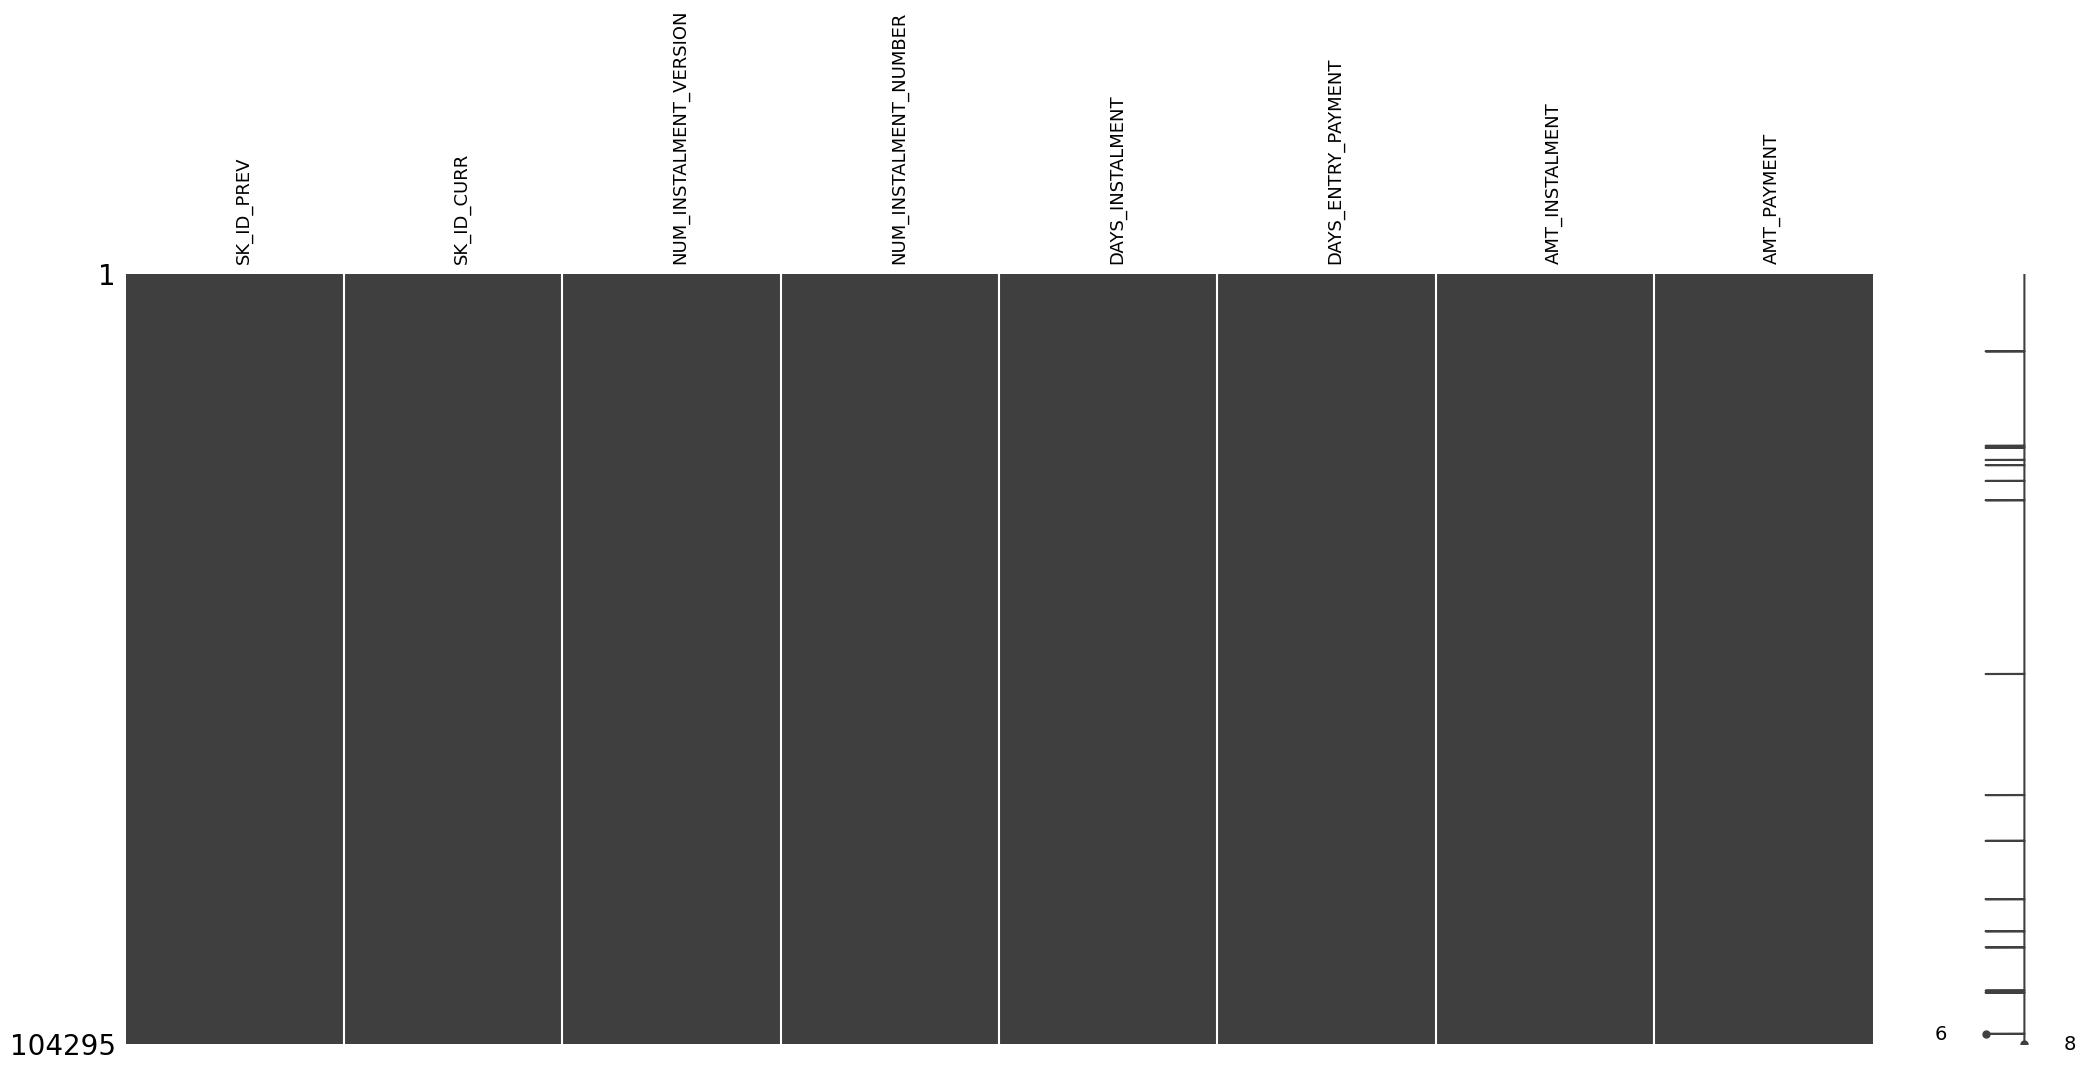

In [ ]:
clean.vm(install, 0.01,'/content/P7_NA/P7_NA_400.png')

In [ ]:
#set_id_install = set(install['SK_ID_CURR'].unique().tolist())
#set_id_POS = set(POS['SK_ID_CURR'].unique().tolist())
#len(set_id_POS)
#len(set_id_install)/len(df)
#len(set_id_install)

In [ ]:
# Q : est-ce que les 94% des POS sont également les 94% de la table installments ?
#common_elements = set_id_install.intersection(set_id_POS)
#len(common_elements)/len(set_id_install)
#oui presque entièrement
#0.99

In [ ]:
install[install['SK_ID_CURR'] == '456255'].sort_values('NUM_INSTALMENT_NUMBER')

In [ ]:
install[install['SK_ID_PREV'] == '1989818'].sort_values('NUM_INSTALMENT_NUMBER')

In [ ]:
install.loc[install['AMT_PAYMENT'].idxmin()]

In [ ]:
install[install['AMT_PAYMENT'] == 0].describe()

In [ ]:
install[(install['SK_ID_PREV'] == '2581676') &
        (install['NUM_INSTALMENT_NUMBER'] == 27)]

In [ ]:
install[(install['SK_ID_PREV'] == '1831493') &
        (install['NUM_INSTALMENT_NUMBER'] == 28)]

In [ ]:
#Je supprime les paiement de montant nul, ils font partis d'une série de paiement.
#Ce qui me confirme que les valeur manquantes sont bien des paiements manqués.
#install[(install['AMT_PAYMENT'] == 0)]
ind_ = install[(install['AMT_PAYMENT'] == 0)].index
install = install.drop(ind_)

In [ ]:
install.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2192
AMT_INSTALMENT               0
AMT_PAYMENT               2192
dtype: int64

In [ ]:
install = install.fillna(0)

In [ ]:
del install

Je suppose que les valeurs manquantes de paiement sont des paiements manqués. Je les impute par 0.

## 4.2 Fonction **install_fonct**

In [ ]:
def filtre(value):
  if value < 0:
    return 0
  else :
    return value

In [ ]:
def install_fonct(chemin, df):
  df_install = pd.read_csv(chemin,
                           #nrows = 10,
                      dtype={'SK_ID_CURR' : 'object',
                             'SK_ID_PREV' : 'object',
                             #'DAYS_ENTRY_PAYMENT' :'float'
                             }
                      )
  df_install = df_install.merge(df[['SK_ID_CURR']], how = 'inner', on = 'SK_ID_CURR')
  df_install['DAYS_ENTRY_PAYMENT'] = df_install['DAYS_ENTRY_PAYMENT'].astype(float)
  #Je supprime les paiement de montant nul, ils font partis d'une série de paiement.
  #Ce qui me confirme que les valeur manquantes sont bien des paiements manqués.
  #install[(install['AMT_PAYMENT'] == 0)]
  ind_ = df_install[(df_install['AMT_PAYMENT'] == 0)].index
  df_install = df_install.drop(ind_)
  df_install = df_install.fillna(0)
  df_install['J_RETARD'] = df_install['DAYS_ENTRY_PAYMENT'] - df_install['DAYS_INSTALMENT']
  df_install['J_RETARD'] = df_install['J_RETARD'].map(filtre)
  df_install = df_install[['SK_ID_PREV',
                           'SK_ID_CURR','J_RETARD', 'NUM_INSTALMENT_NUMBER',
                           'AMT_INSTALMENT', 'AMT_PAYMENT']]
  install_agg = df_install.groupby(['SK_ID_CURR','SK_ID_PREV', 'NUM_INSTALMENT_NUMBER']).agg({'J_RETARD': 'max',
                                                                                              'AMT_INSTALMENT': ['max'],
                                                                                              'AMT_PAYMENT': ['sum'], }).reset_index()
  del df_install
  install_agg.columns = pd.Index(['INST_' + e[0] + "_" + e[1].upper() for e in install_agg.columns.tolist()] )

  install_agg['INST_RESTE_A_PAYER'] = install_agg['INST_AMT_INSTALMENT_MAX']- install_agg['INST_AMT_PAYMENT_SUM']
  install_agg = install_agg.drop(columns =['INST_SK_ID_PREV_', 'INST_NUM_INSTALMENT_NUMBER_'])
  install_agg = install_agg.groupby('INST_SK_ID_CURR_').agg({'INST_J_RETARD_MAX': 'mean',
                                                             'INST_RESTE_A_PAYER' : 'sum'}).reset_index()
  install_agg = install_agg.rename(columns = {'INST_SK_ID_CURR_': 'SK_ID_CURR',
                                             })
  print(install_agg.columns)
  print(install_agg)
  return install_agg


In [ ]:
install = install_fonct('/content/installments_payments.csv', df)

Index(['SK_ID_CURR', 'INST_J_RETARD_MAX', 'INST_RESTE_A_PAYER'], dtype='object')
      SK_ID_CURR  INST_J_RETARD_MAX  INST_RESTE_A_PAYER
0         100001           1.571429        0.000000e+00
1         100005           0.111111        0.000000e+00
2         100013           0.579310        3.637979e-12
3         100028           0.281553       -2.842171e-14
4         100038           0.000000        0.000000e+00
...          ...                ...                 ...
47939     456221           0.000000        0.000000e+00
47940     456222           0.542857        0.000000e+00
47941     456223           0.000000        0.000000e+00
47942     456224           0.034483        0.000000e+00
47943     456250           0.428571        0.000000e+00

[47944 rows x 3 columns]


In [ ]:
install.to_csv('/content/P7_NA/install_test_set_1.csv', index=False)

In [ ]:
del install

À ce stade j'identifie différent type d'offre de financement :


*   Le prêt à la consommation (cash loans)
*   Le paiement en plusieurs fois directement dans un point de vente, offres gérées par Home Credit
*   Le paiement par carte de crédit Home Credit.



# <a name=C5> 5. Tables bureau.csv et bureau_balance.csv <a>

In [ ]:
bureau = pd.read_csv('/content/bureau.csv', #nrows = 5000,
                      dtype={'SK_ID_CURR' : 'object',
                             'SK_BUREAU_ID' : 'object',
                             }
                      )

b_balance = pd.read_csv('/content/bureau_balance.csv', #nrows = 5000,
                      dtype={'SK_BUREAU_ID' : 'object',
                             }
                      )

In [ ]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
id_bur = set(bureau['SK_ID_BUREAU'].unique().tolist())
len(id_bur)

1716428

In [ ]:
id_bb = set(b_balance['SK_ID_BUREAU'].unique().tolist())
len(id_bb)

817395

Il y a 1 million d'identifiant non répertorié dans bureau balance. Ce qui explique les valeurs manquantes

In [ ]:
bureau[bureau['SK_ID_CURR'] == '215354']

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.8,42103.80,0.00,0.0,Consumer credit,-22,NaN
225157,215354,5714458,Closed,currency 1,-1872,0,-776.0,-1203.0,NaN,0,494550.0,0.00,0.00,0.0,Consumer credit,-696,NaN
225158,215354,5714459,Closed,currency 1,-1734,0,-638.0,-1336.0,NaN,0,1084032.0,0.00,NaN,0.0,Car loan,-1336,NaN
225159,215354,5714460,Closed,currency 1,-1333,0,-1089.0,-987.0,NaN,0,102150.0,NaN,NaN,0.0,Consumer credit,-984,NaN


In [ ]:
b_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
b_balance['STATUS'].unique()

array(['C', '0', 'X', '1', '2'], dtype=object)

SK_ID_BUREAU      0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64

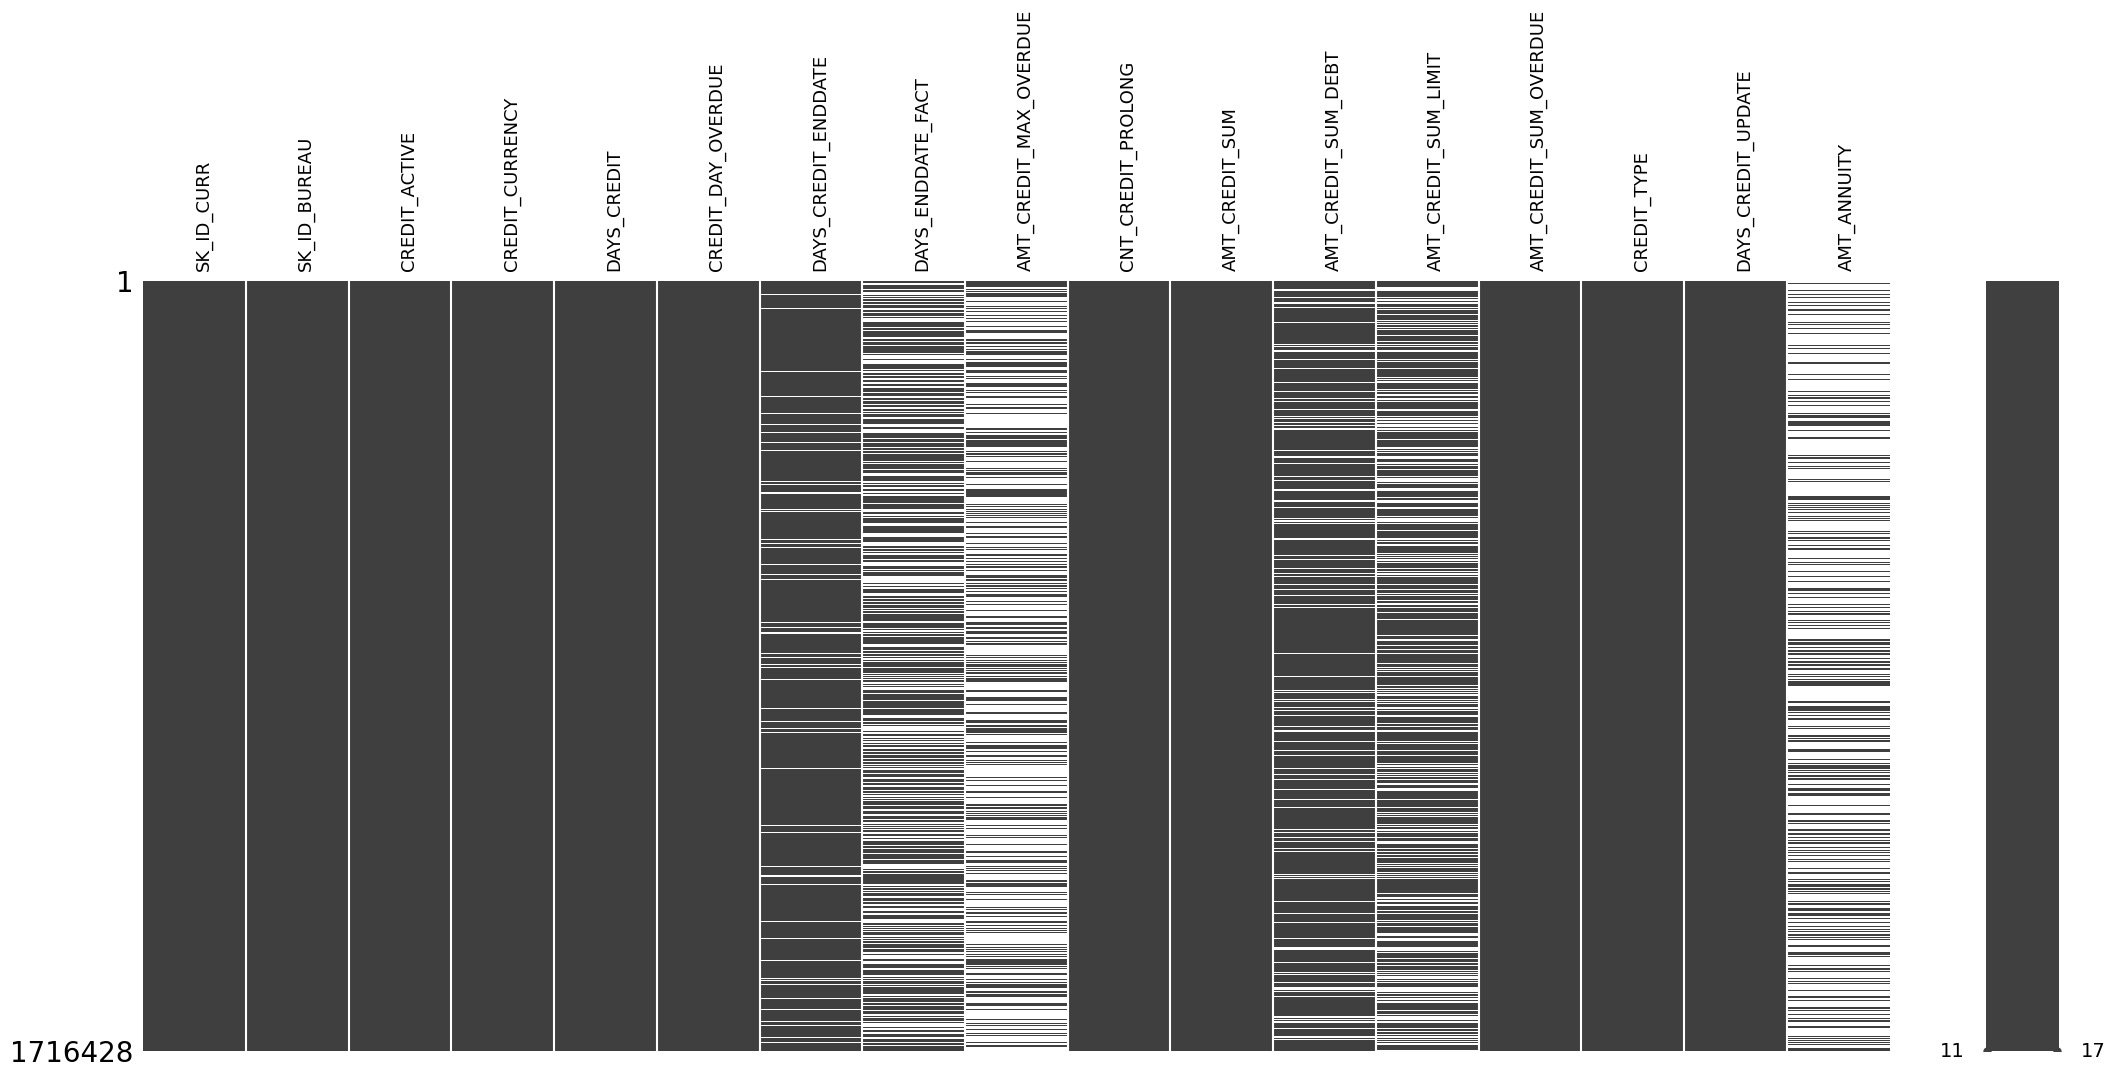

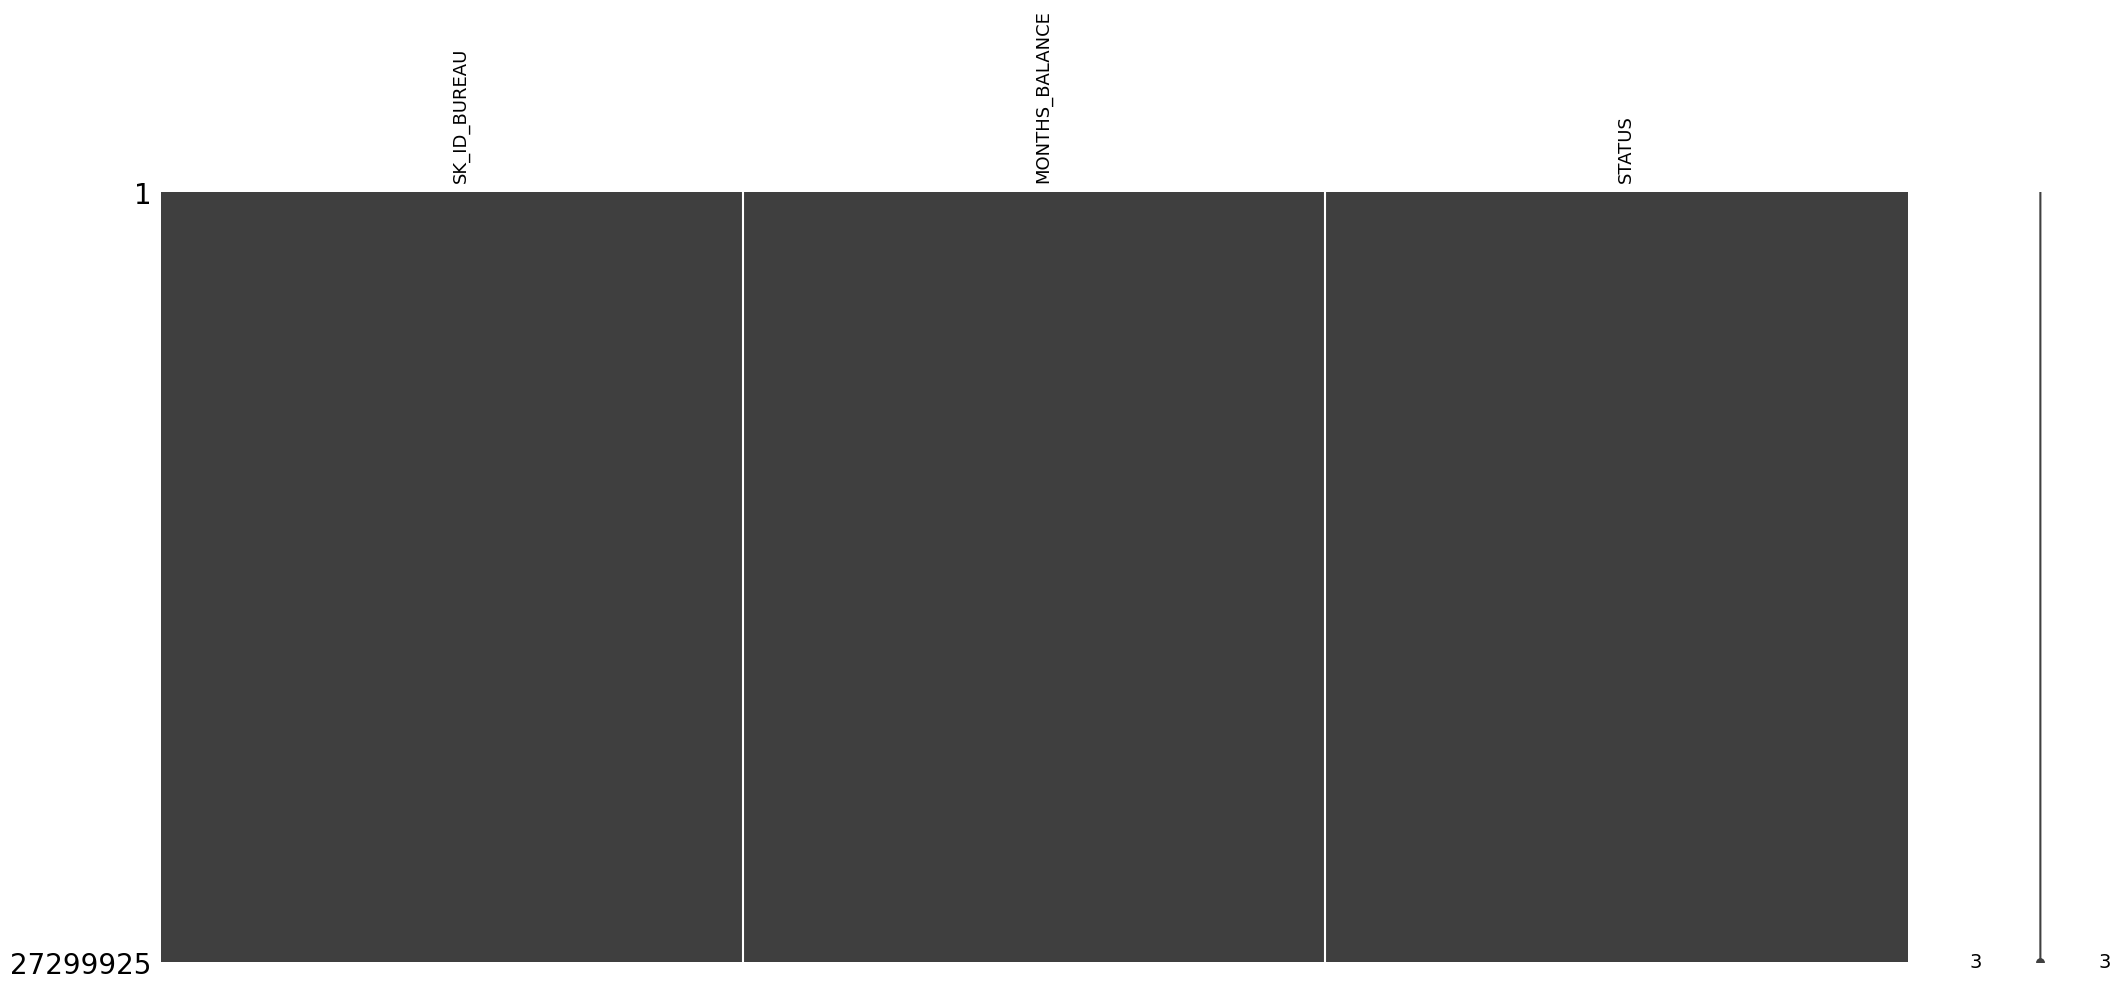

In [ ]:
clean.vm(bureau,1,'/content/P7_NA/P7_NA_500a.png' )
clean.vm(b_balance,1,'/content/P7_NA/P7_NA_500b.png' )

## 5.1 Visualisation

In [ ]:
idx_max_months_balance = b_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax()

# Use the index to retrieve the corresponding 'STATUS' values
result = b_balance.loc[idx_max_months_balance, ['SK_ID_BUREAU','STATUS']]

# Example usage
print(result)


      SK_ID_BUREAU STATUS
0          5715448      C
27         5715449      C
39         5715451      C
65         5715452      C
98         5715453      C
...            ...    ...
4771       5719289      0
4798       5719290      0
4830       5719291      C
4881       5719292      C
4943       5719294      C

[141 rows x 2 columns]


In [ ]:
b_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
b_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax()

SK_ID_BUREAU
5715448       0
5715449      27
5715451      39
5715452      65
5715453      98
           ... 
5719289    4771
5719290    4798
5719291    4830
5719292    4881
5719294    4943
Name: MONTHS_BALANCE, Length: 141, dtype: int64

In [ ]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
def filtre(value):
  if value < 0:
    return 0
  else :
    return value

In [ ]:
del bureau
del b_balance

In [ ]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(chemin_,df, num_rows = None):
    bureau = pd.read_csv(chemin_+'/bureau.csv', #nrows = 10,
                         dtype={'SK_ID_CURR' : 'object',
                                'SK_BUREAU_ID' : 'object',
                             })
    #print('check 0')
    bureau = bureau.merge(df['SK_ID_CURR'], how = 'inner', on = 'SK_ID_CURR')
    #print('check merge')
    ####------------------------- Bureau balance
    bb = pd.read_csv(chemin_+'/bureau_balance.csv', #nrows = 10,
                     dtype={'SK_BUREAU_ID' : 'object',
                             })
    #print('check 1')
    bb_aggregations = {'MONTHS_BALANCE': ['max', 'min']}
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations).reset_index()
    del bb
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    print(bb_agg.columns)
    print(bb_agg)
    bureau = bureau.merge(bb_agg, how='left', left_on='SK_ID_BUREAU', right_on = 'SK_ID_BUREAU_')
    #bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb_agg

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['max'],
        #'DAYS_CREDIT_ENDDATE': ['max'],
        'CREDIT_DAY_OVERDUE': ['max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['sum'],
        'AMT_ANNUITY': ['sum'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_MIN': ['min'],
        'SK_ID_BUREAU_' : ['count']
    }
    bureau_agg = bureau.groupby('SK_ID_CURR').agg(num_aggregations).reset_index()
    bureau_agg.columns = pd.Index(['BUR_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    print(bureau_agg.columns)
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE'] == 'Active']
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations).reset_index()
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.merge(active_agg, how='left', left_on = 'BUR_SK_ID_CURR_', right_on='ACTIVE_SK_ID_CURR_')
    del active, active_agg
    print(bureau_agg.columns)
    bureau_agg = bureau_agg[['BUR_SK_ID_CURR_','ACTIVE_DAYS_CREDIT_MAX',
                             #'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
                             'BUR_CREDIT_DAY_OVERDUE_MAX', 'BUR_AMT_CREDIT_SUM_OVERDUE_SUM',
                             'BUR_MONTHS_BALANCE_MIN_MIN','ACTIVE_SK_ID_BUREAU__COUNT', 'BUR_SK_ID_BUREAU__COUNT',
                             'ACTIVE_AMT_ANNUITY_SUM', 'ACTIVE_MONTHS_BALANCE_MAX_MAX','ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']]

    bureau_agg = bureau_agg.rename(columns = {'BUR_SK_ID_CURR_' : 'SK_ID_CURR',
                                              'ACTIVE_DAYS_CREDIT_MAX': 'CB_RECENCE_APPL',
                                             #'ACTIVE_DAYS_CREDIT_ENDDATE_MIN' : 'CB_J_RESTANT',
                                              'BUR_CREDIT_DAY_OVERDUE_MAX' : 'CB_J_RETARD',
                                              'BUR_MONTHS_BALANCE_MIN_MIN' : 'CB_ANCIENNETE_MOIS',
                                              'ACTIVE_SK_ID_BUREAU__COUNT' : 'CB_NBRE_CONTRAT_ACTIF',
                                              'BUR_SK_ID_BUREAU__COUNT': 'CB_NBRE_CONTRAT_TOTAL',
                                              'ACTIVE_AMT_ANNUITY_SUM' : 'CB_REMB_ANNUEL_TOTAL',
                                              'ACTIVE_MONTHS_BALANCE_MAX_MAX' : 'CB_RECENCE_ACTIVITE',
                                              'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM' : 'CB_RESTE_A_PAYER',
                                              'BUR_AMT_CREDIT_SUM_OVERDUE_SUM' : 'CB_SOMME_DUES_RETARD'
                                             })
    return bureau_agg


In [ ]:
b_b = bureau_and_balance('/content', df)

Index(['SK_ID_BUREAU_', 'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_MIN'], dtype='object')
        SK_ID_BUREAU_  MONTHS_BALANCE_MAX  MONTHS_BALANCE_MIN
0             5001709                   0                 -96
1             5001710                   0                 -82
2             5001711                   0                  -3
3             5001712                   0                 -18
4             5001713                   0                 -21
...               ...                 ...                 ...
817390        6842884                   0                 -47
817391        6842885                   0                 -23
817392        6842886                   0                 -32
817393        6842887                   0                 -36
817394        6842888                   0                 -61

[817395 rows x 3 columns]
Index(['BUR_SK_ID_CURR_', 'BUR_DAYS_CREDIT_MAX', 'BUR_CREDIT_DAY_OVERDUE_MAX',
       'BUR_AMT_CREDIT_SUM_MAX', 'BUR_AMT_CREDIT_SUM_MEAN',
     

In [ ]:
b_b.head()

,SK_ID_CURR,CB_RECENCE_APPL,CB_J_RETARD,CB_SOMME_DUES_RETARD,CB_ANCIENNETE_MOIS,CB_NBRE_CONTRAT_ACTIF,CB_NBRE_CONTRAT_TOTAL,CB_REMB_ANNUEL_TOTAL,CB_RECENCE_ACTIVITE,CB_RESTE_A_PAYER
0,100001,-49.0,0,0.0,-51.0,3.0,7,24817.500,0.0,596686.500
1,100005,-62.0,0,0.0,-12.0,2.0,3,4261.500,0.0,568408.500
2,100013,NaN,0,0.0,-68.0,NaN,4,NaN,NaN,NaN
3,100028,-269.0,0,0.0,-69.0,5.0,12,21084.075,0.0,186304.500
4,100042,-234.0,0,0.0,-89.0,8.0,14,136309.500,0.0,3074162.895


In [ ]:
b_b.to_csv('/content/P7_NA/Bureau_test_set_1.csv', index = False)

In [ ]:
del b_b

# Téléchargement dossier P7_NA

In [ ]:
import shutil
from google.colab import files

folder_name = 'P7_NA'

# Zip the 'graphs' folder
shutil.make_archive(folder_name, 'zip', folder_name)

# Download the zip file
files.download(folder_name+'.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>